In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights
from rcgp.rcgp import RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 24,
    'lines.linewidth': 5,    
    'lines.markersize': 6   
})

In [2]:
def apply_overlap(y_train, overlap_ratio):
    N, D = y_train.shape
    indices = np.arange(N)

    # Number of shared (overlap) indices
    n_overlap = int(overlap_ratio * N)

    # Select overlap indices common to all output functions
    shared_indices = np.random.choice(indices, size=n_overlap, replace=False)

    # Initialize all to NaN
    y_obs = np.full_like(y_train, np.nan)

    # Set the shared overlap values
    y_obs[shared_indices, :] = y_train[shared_indices, :]

    # Remaining indices to distribute uniquely across each output
    remaining_indices = np.setdiff1d(indices, shared_indices)

    n_unique_per_output = (N - n_overlap) // D

    for d in range(D):
        # Randomly assign unique indices to each output from remaining pool
        if d < D - 1:
            chosen = np.random.choice(remaining_indices, size=n_unique_per_output, replace=False)
            remaining_indices = np.setdiff1d(remaining_indices, chosen)
        else:
            # Assign all remaining indices to the last output (in case of uneven division)
            chosen = remaining_indices
        y_obs[chosen, d] = y_train[chosen, d]

    return y_obs

## MOGP

[[1.       0.9     ]
 [0.9      1.000096]]


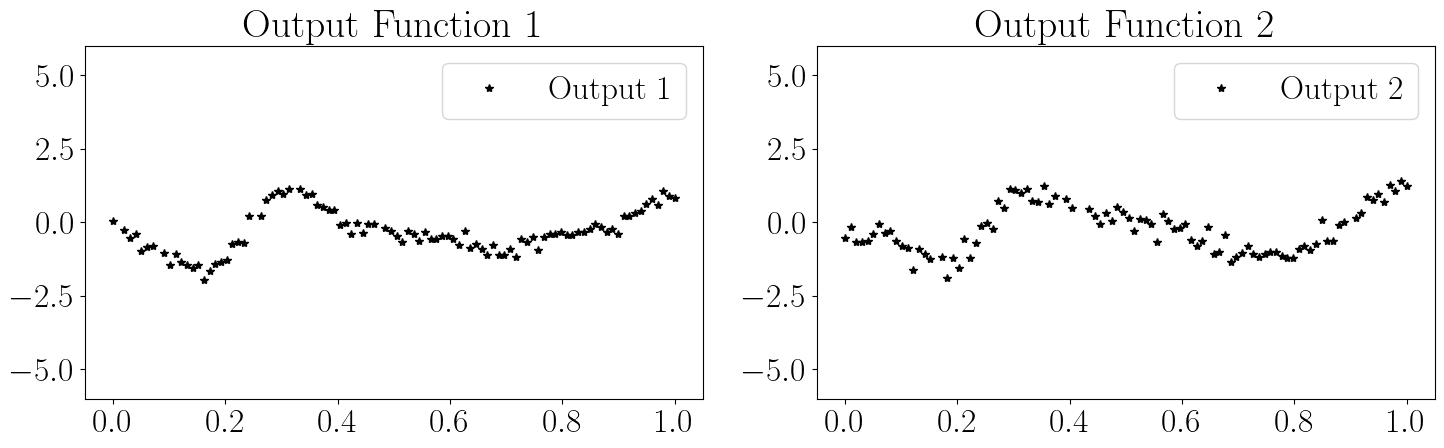

In [6]:
np.random.seed(42)

# Initialisation
constant_mean = 0
length_scale = 0.1
variance = 1
n_outputs = 2
n_points = 100
overlap_ratio = 0.9

A = np.array([[1, 0], 
              [0.9, 0.436]])
B = A @ A.T
print(B)

D = B.shape[0]

# noise = np.array([0.01, 0.16])
noise = np.array([0.04, 0.09])
if noise.shape[0] == 1:
    noise_matrix = noise * np.eye(D)
else:
    noise_matrix = np.diag(noise)

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.linspace(0, 1, n_points).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_matrix, np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

y_train = apply_overlap(y_train, overlap_ratio)

# indices_025 = np.where((x_train >= 0.20) & (x_train <= 0.30))[0]
# outlier_indices_025 = np.random.choice(indices_025, 1, replace=False)
# y_train[outlier_indices_025, 0] = -5

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Output {i+1}')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

Optimized length_scale: 0.0817
Optimized noise: [0.02883681 0.07001931]
Optimized A: [[ 0.78687208 -0.00290188]
 [ 0.70400453  0.34269583]]
Optimized B: 
[[0.6191761  0.55296705]
 [0.55296705 0.61306282]]


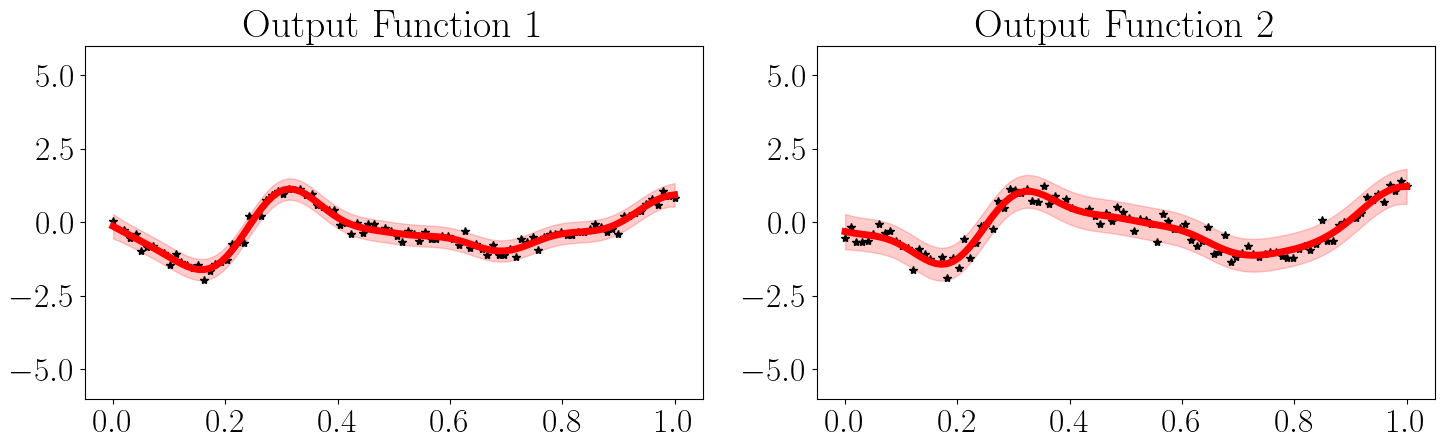

In [ ]:
# Instantiate and train
# mogp = MOGPRegressor(mean = 0, length_scale=0.1, noise = noise, A=A)
mogp = MOGPRegressor_NC(mean = 0, length_scale=0.1, noise = 0.04, A=A)
mogp.fit(x_train, y_train)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
# mogp.optimize_loo_cv(print_opt_param=True, print_iter_param=True)

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = mogp.predict(x_test)
std = np.sqrt(var + mogp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')
    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    # axs[i].legend()

plt.tight_layout()
plt.show()

## MORCGP - cross channel predictive

[[1.999396 1.200486]
 [1.200486 1.000642]]


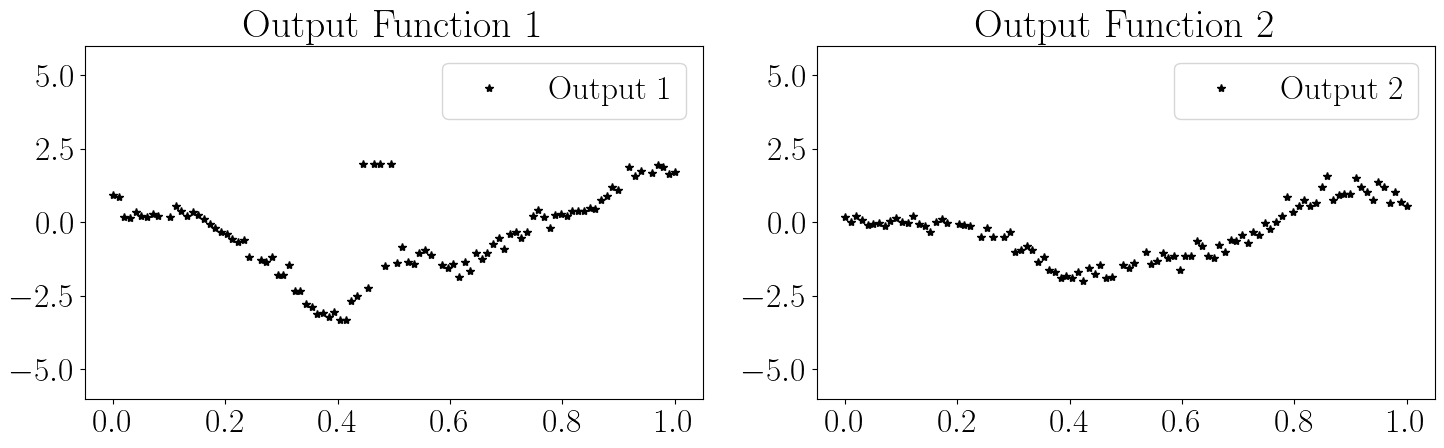

In [3]:
np.random.seed(10)

# Initialisation
constant_mean = 0
length_scale = 0.1
variance = 1
n_outputs = 2
n_points = 100
overlap_ratio = 0.9

noise_variance = 0.04

A = np.array([[1.414, 0], 
    [0.849, 0.529]])
B = A @ A.T
print(B)

D = B.shape[0]

# noise = np.array([0.01, 0.16])
noise = np.array([0.04, 0.04])
if noise.shape[0] == 1:
    noise_matrix = noise * np.eye(D)
else:
    noise_matrix = np.diag(noise)

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.linspace(0, 1, n_points).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_matrix, np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

y_train = apply_overlap(y_train, overlap_ratio)

indices_025 = np.where((x_train >= 0.40) & (x_train <= 0.50))[0]
outlier_indices_025 = np.random.choice(indices_025, int(4), replace=False)
y_train[outlier_indices_025, 0] = 2

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Output {i+1}')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

In [4]:
# Instantiate and train
mogp = MOGPRegressor(mean = 0, length_scale=0.1, noise = noise, A=A)
mogp.fit(x_train, y_train)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_B = mogp.B
optim_noise = mogp.noise

Optimized length_scale: 0.0844
Optimized noise: [0.4712544 0.0427548]
Optimized A: [[ 1.42735623 -0.10364506]
 [ 0.49767964  0.48410028]]
Optimized B: 
[[2.04808812 0.66019154]
 [0.66019154 0.48203811]]


8.53670616313563
8.536706051487561
8.536705922224627
8.536706222576866
8.53670623562612
8.536706151897057
8.536706035400336
-6.542458362010011
-6.542458224489177
-6.5424584098649525
-6.542458576430574
-6.542458312769489
-6.54245801429491
-6.542458471438004
12.5511639800767
12.551163986563983
12.551163773345863
12.551163983202171
12.551163983113652
12.5511639940641
12.551163982622185
16.875901965212844
16.87590203610178
16.875901938614785
16.875901879355446
16.875902017504256
16.875902078523026
16.875901921917766
14.565362716168762
14.565362663813694
14.565362555735792
14.565362879106821
14.565362148448687
14.565362485890166
14.565363460316437
17.829147649040905
17.82914767010924
17.8291475846065
17.829147591087462
17.829147552045665
17.829147699348514
17.829147815203275
18.980405640529778
18.980405630163414
18.98040559613347
18.980405616530426
18.980405589906216
18.98040564009712
18.980405710052395
19.270097461866946
19.270097436098276
19.270097450131484
19.270097517762938
19.270097458

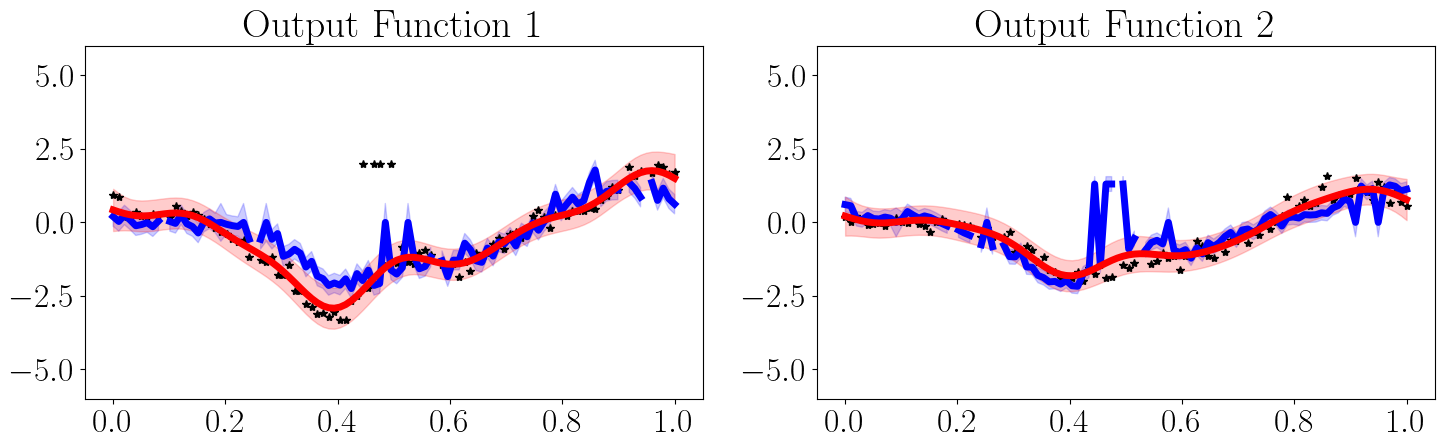

In [5]:
# Instantiate and train
# morcgp = MORCGPRegressor(mean = 0, length_scale=0.1, noise = noise, A=A)
morcgp = MORCGPRegressor_NC(mean = 0, length_scale=0.1, noise = 0.04, A=A)
predictive_mean, predictive_variances = morcgp.fit(x_train, y_train)

# print(morcgp.loo_cv(length_scale=0.1, noise=0.04, A=A, weighted=True, B_weighted=B))

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True, B_weighted=optim_B, noise_weighted=optim_noise)
predictive_mean, predictive_variances = morcgp.fit(x_train, y_train)

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = morcgp.predict(x_test)
std = np.sqrt(var + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')

    axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    axs[i].fill_between(x_test.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

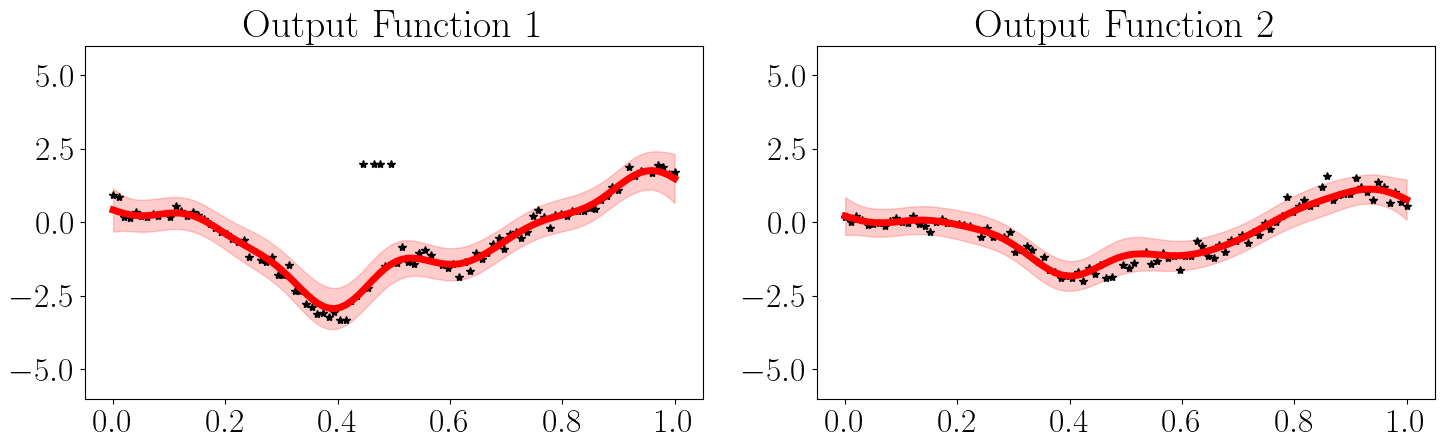

In [7]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')

    # axs[i].plot(x_train.flatten(), ((morcgp.weights_01.reshape(n_outputs,-1).T))[:,i], '_', color='red', label=f'Predictive Mean', markersize=10)

    # axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x_test.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

## Fixed weights

[[1.999396 1.200486]
 [1.200486 1.000642]]


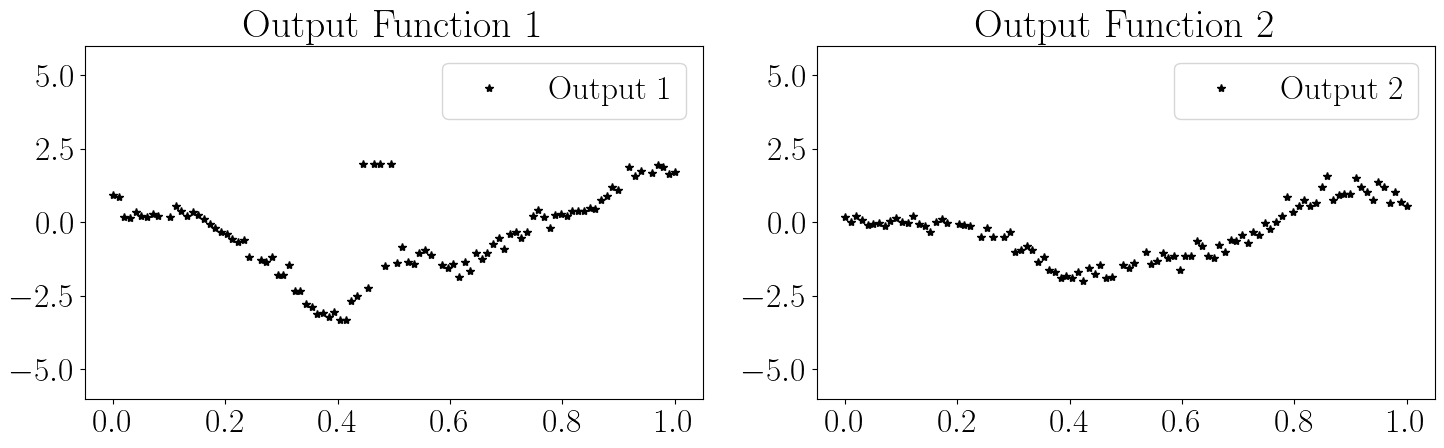

In [3]:
np.random.seed(10)

# Initialisation
constant_mean = 0
length_scale = 0.1
variance = 1
n_outputs = 2
n_points = 100
overlap_ratio = 0.9

noise_variance = 0.04

A = np.array([[1.414, 0], 
    [0.849, 0.529]])
B = A @ A.T
print(B)

D = B.shape[0]

# noise = np.array([0.01, 0.16])
noise = np.array([0.04, 0.04])
if noise.shape[0] == 1:
    noise_matrix = noise * np.eye(D)
else:
    noise_matrix = np.diag(noise)

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.linspace(0, 1, n_points).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_matrix, np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

y_train = apply_overlap(y_train, overlap_ratio)

indices_025 = np.where((x_train >= 0.40) & (x_train <= 0.50))[0]
outlier_indices_025 = np.random.choice(indices_025, int(4), replace=False)
y_train[outlier_indices_025, 0] = 2

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Output {i+1}')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

In [4]:
# Instantiate and train
mogp = MOGPRegressor_NC(mean = 0, length_scale=0.1, noise = 0.04, A=A)
mogp.fit(x_train, y_train)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_length_scale = mogp.length_scale
optim_A = mogp.A
optim_B = mogp.B
optim_noise = mogp.noise

Optimized length_scale: 0.0606, noise: 0.225270
Optimized A: [[ 1.32767461 -0.06468117]
 [ 0.55688329  0.45796989]]
Optimized B: 
[[1.76690353 0.70973777]
 [0.70973777 0.51985541]]


-413.18978073739936
-413.1897808867524
-413.18976998864906
-413.1897806540416
-413.18978075665626
-413.18978083427845
-413.1897807656843
-53.275250222972964
-53.27525039024115
-53.27525035402496
-53.27525017734631
-53.27525021556387
-53.27525026035206
-53.27525025903359
-52.86762970356346
-52.867629841038394
-52.86762979702452
-52.8676296615615
-52.86762969427028
-52.86762974038549
-52.867629742482166
-51.96924443375225
-51.969244434163095
-51.969244374518006
-51.96924440915327
-51.96924441442259
-51.969244468851144
-51.96924448945848
-51.70730803285585
-51.707308016288856
-51.70730797534817
-51.707308010489925
-51.70730800990346
-51.70730806914648
-51.707308096136394
-50.54003528919313
-50.540035230484904
-50.54003523893273
-50.54003527268858
-50.540035250539695
-50.54003533240844
-50.54003539083674
-62.98049523748443
-62.98049501776357
-62.98049535849466
-62.980495457413305
-62.98049415223833
-62.98049438223809
-62.98049967221512
-50.47207644845666
-50.472076388796644
-50.47207639869

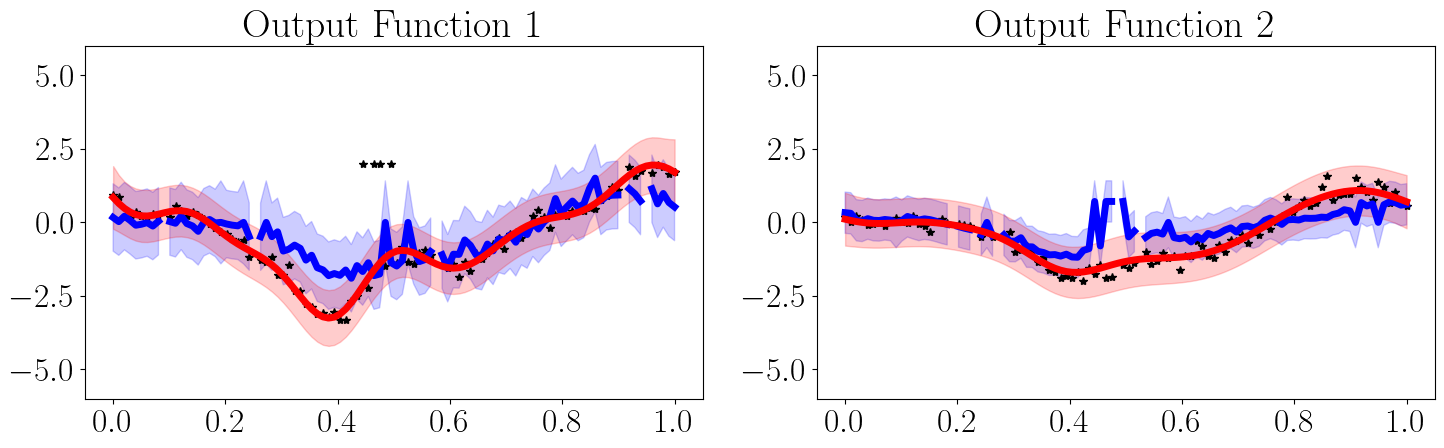

In [5]:
# Instantiate and train
morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_length_scale, noise = optim_noise, A=A)
predictive_mean, predictive_variances = morcgp.fit(x_train, y_train, B_weighted=optim_B, noise_weighted=optim_noise)

# print(morcgp.loo_cv(length_scale=0.1, noise=0.04, A=A, weighted=True, B_weighted=B))

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=False, print_opt_param = True, print_iter_param=True)

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = morcgp.predict(x_test)
std = np.sqrt(var + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')

    axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    axs[i].fill_between(x_test.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

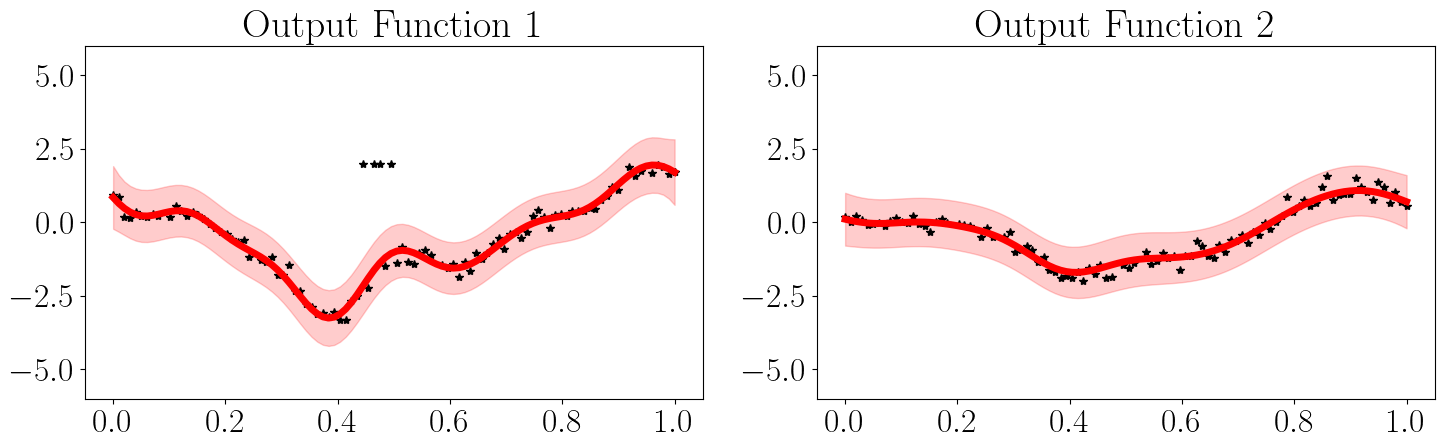

In [6]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')

    # axs[i].plot(x_train.flatten(), ((morcgp.weights_01.reshape(n_outputs,-1).T))[:,i], '_', color='red', label=f'Predictive Mean', markersize=10)

    # axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x_test.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

## Plot

502
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


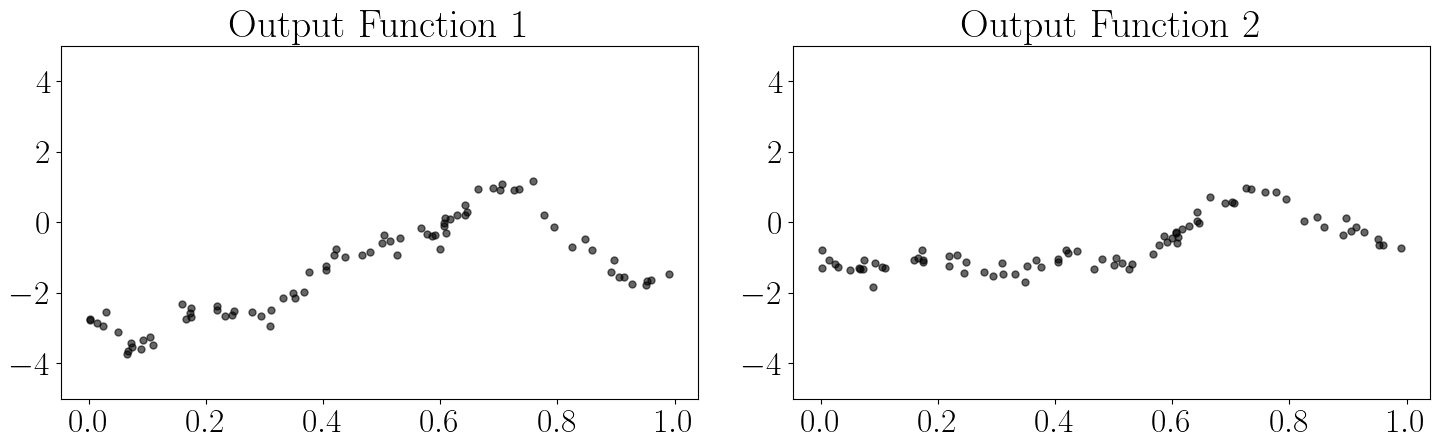

504
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


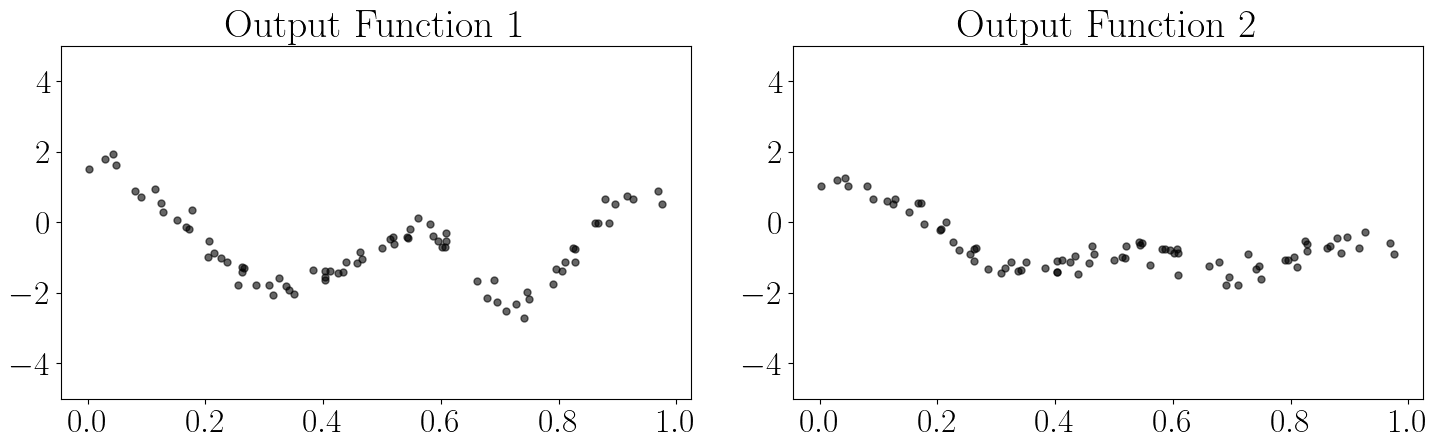

507
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


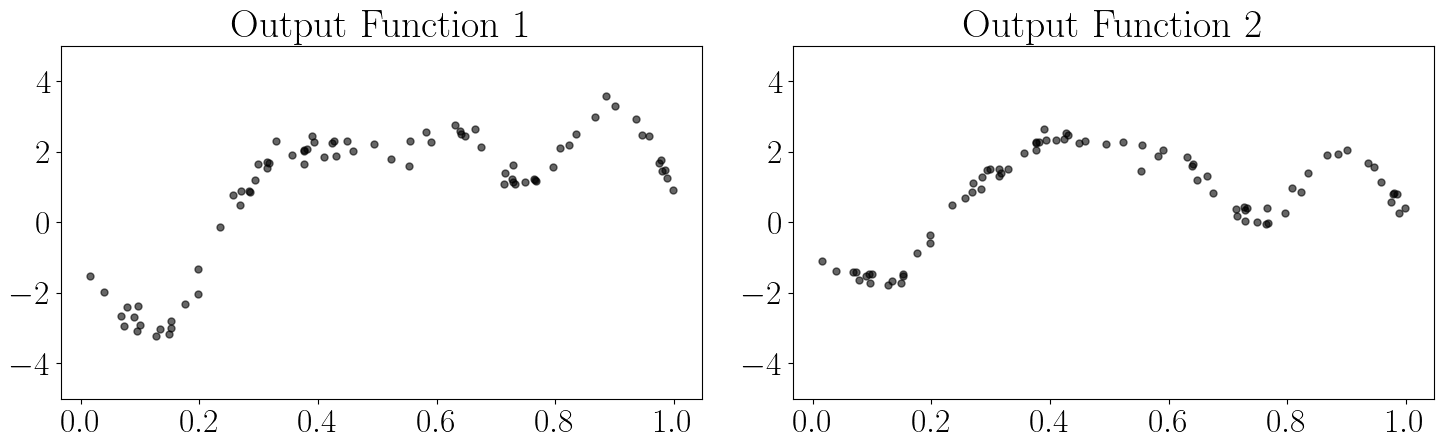

510
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


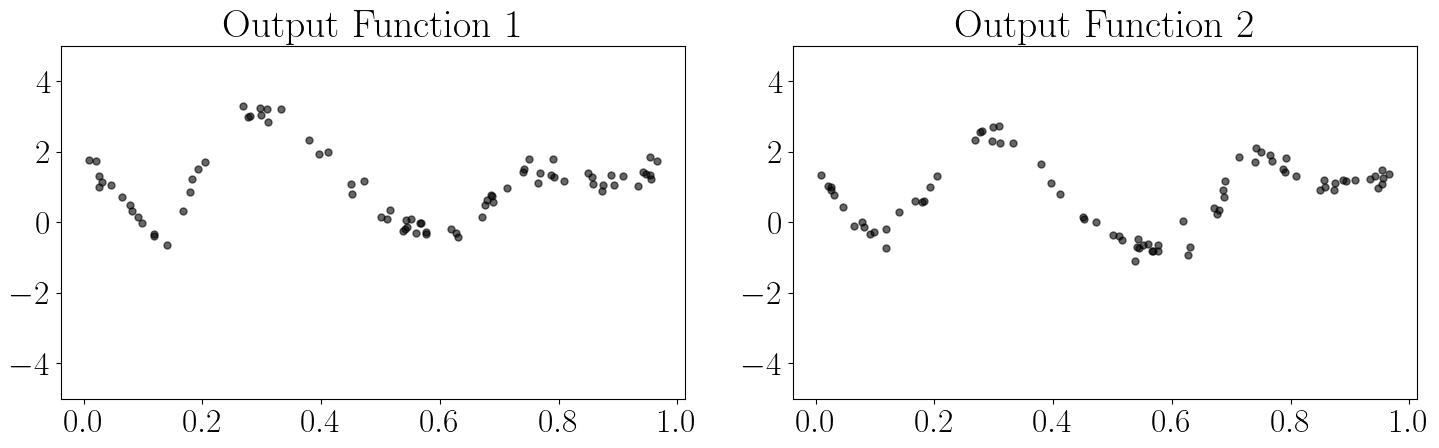

512
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


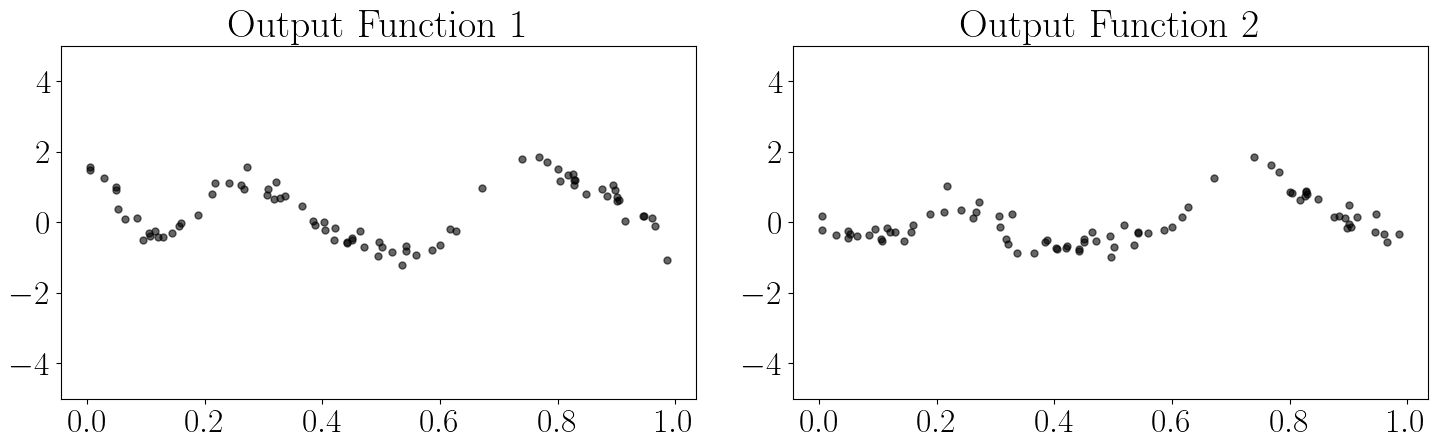

516
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


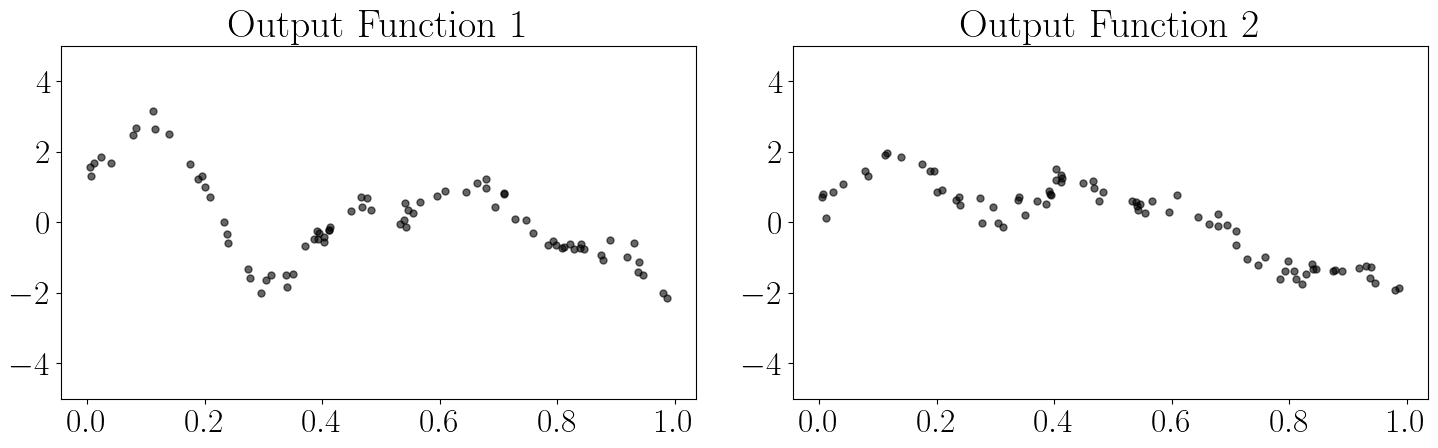

521
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


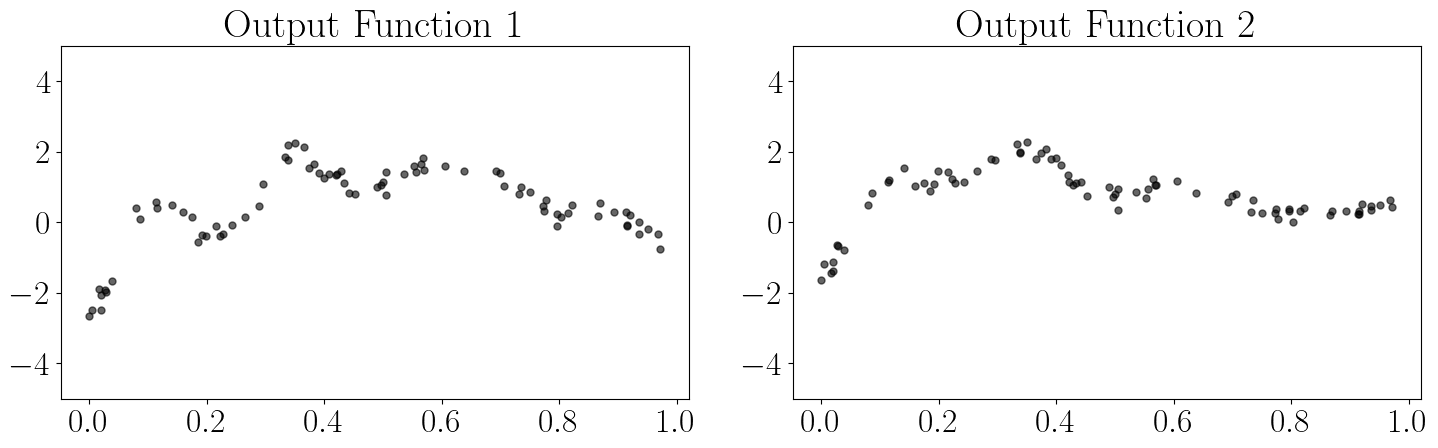

522
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


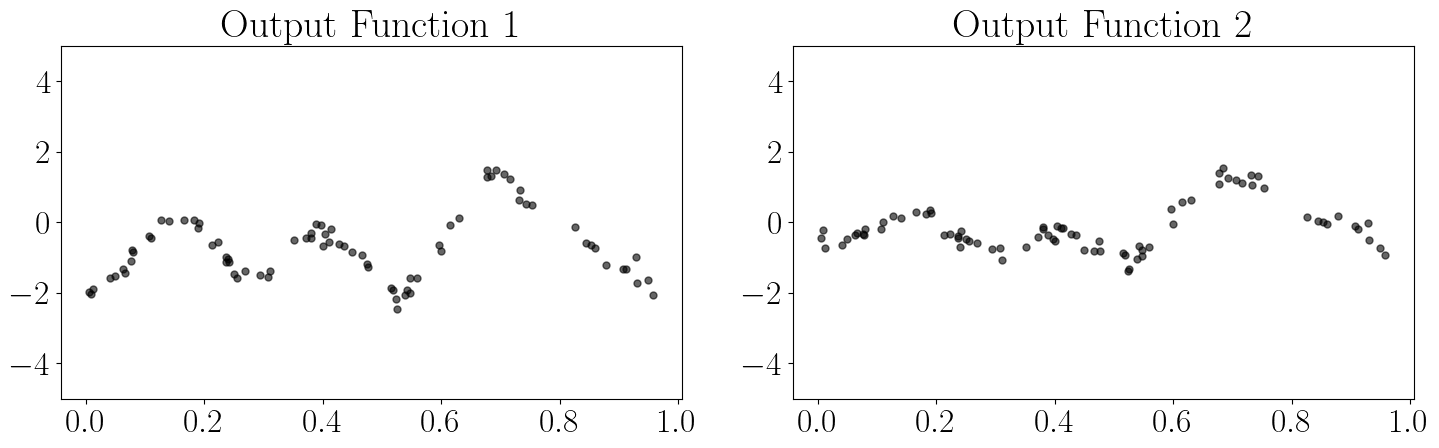

529
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


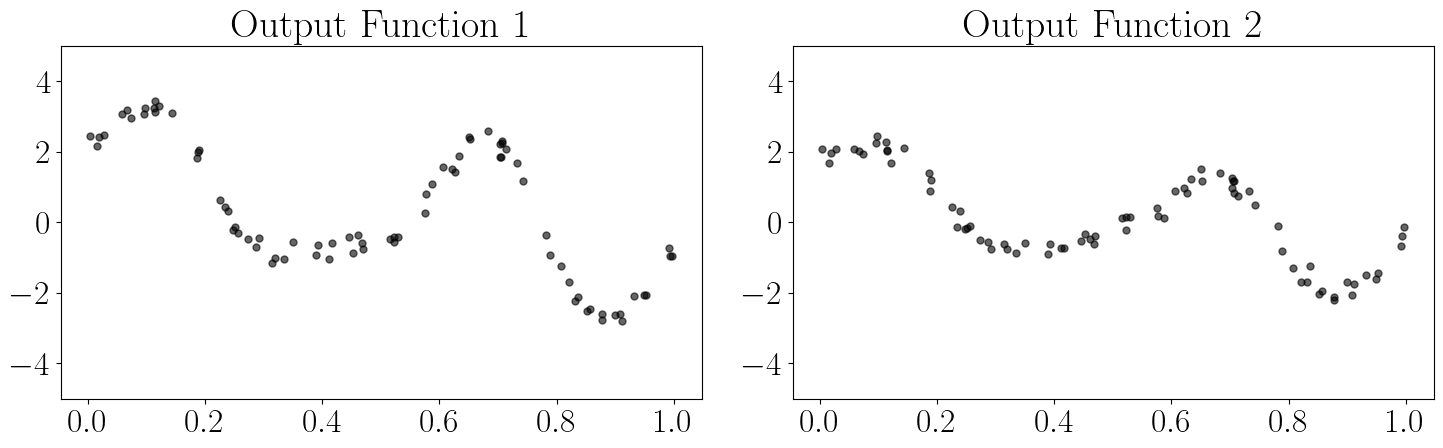

530
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


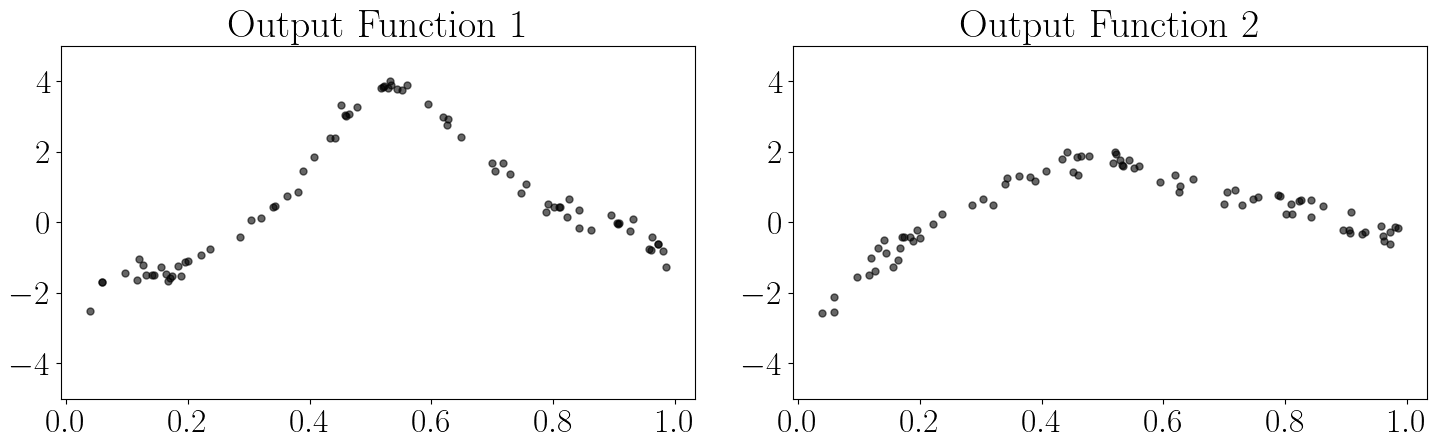

532
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


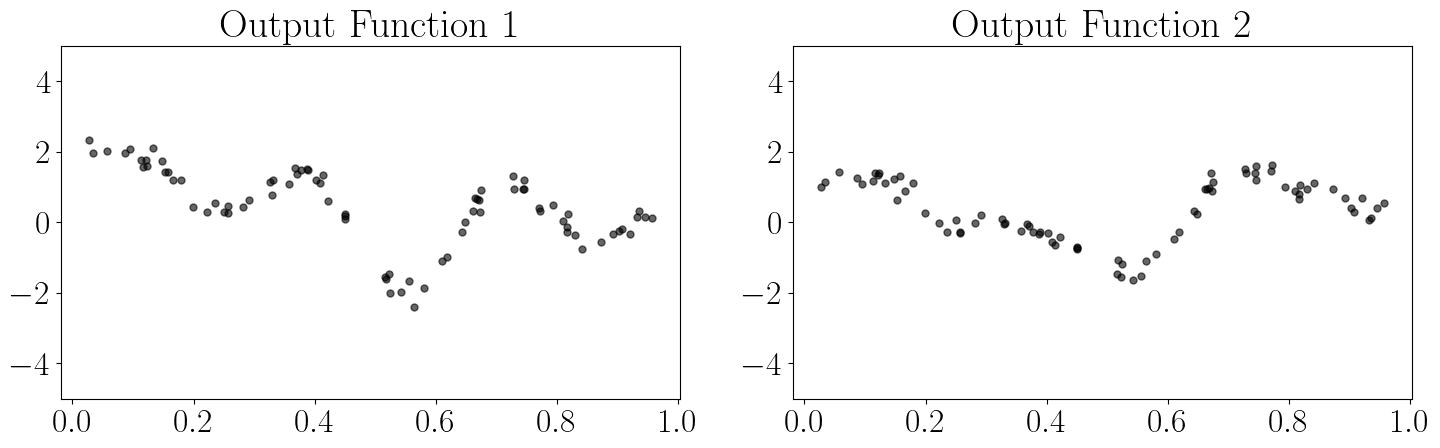

545
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


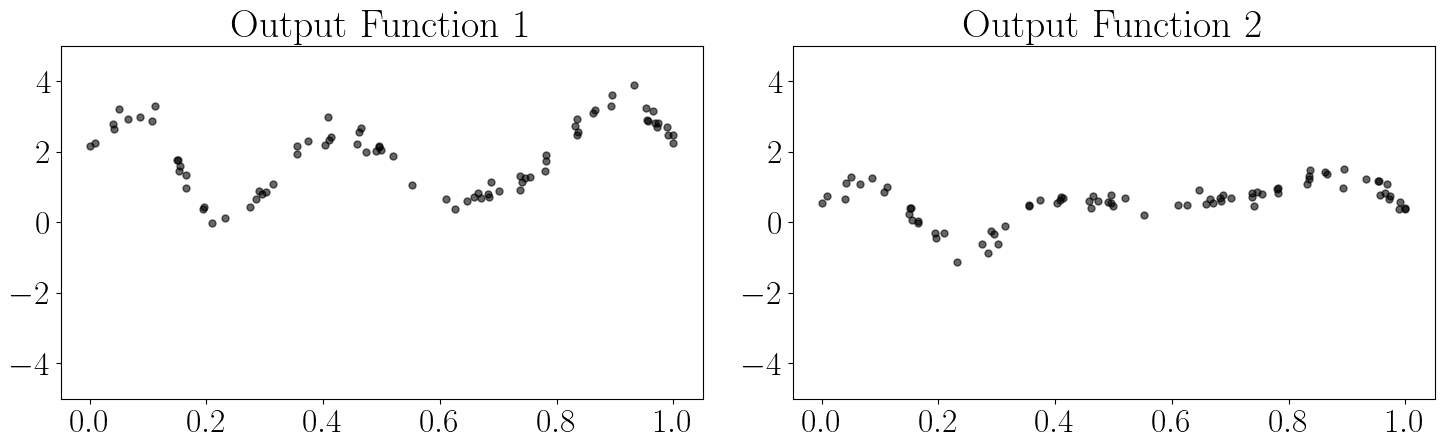

546
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


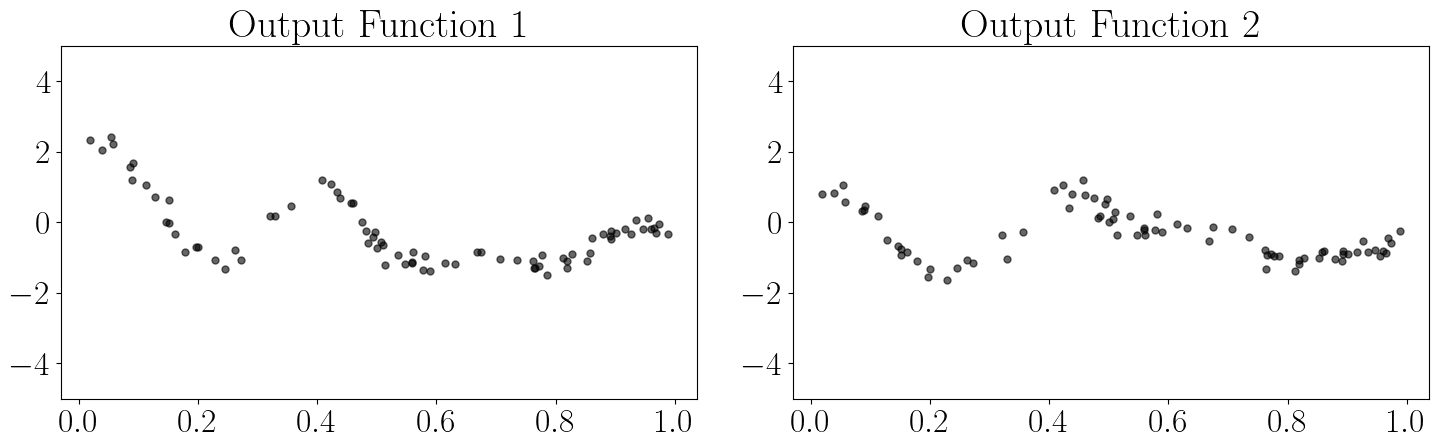

564
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


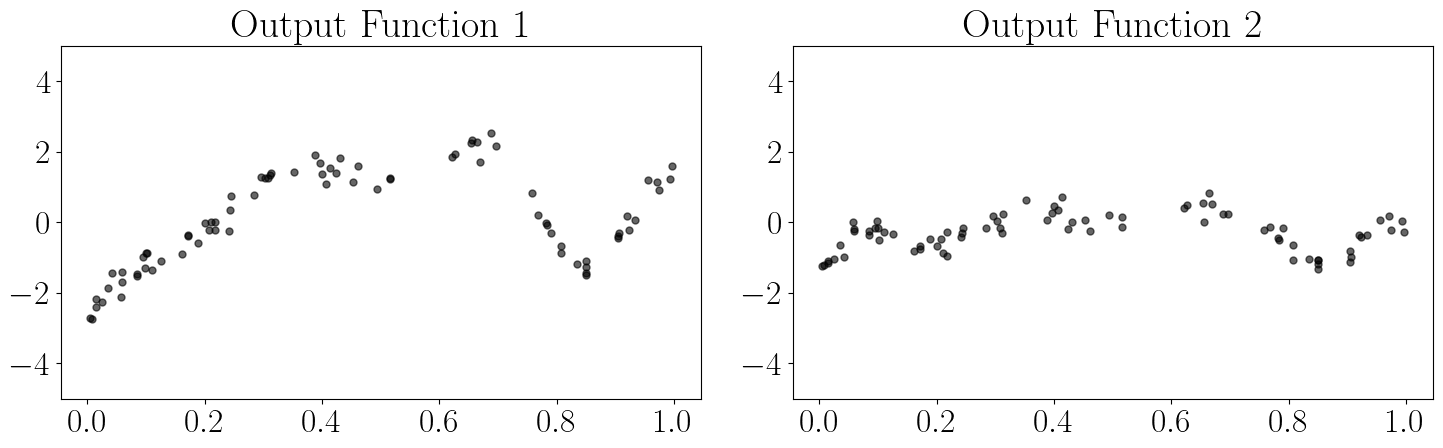

566
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


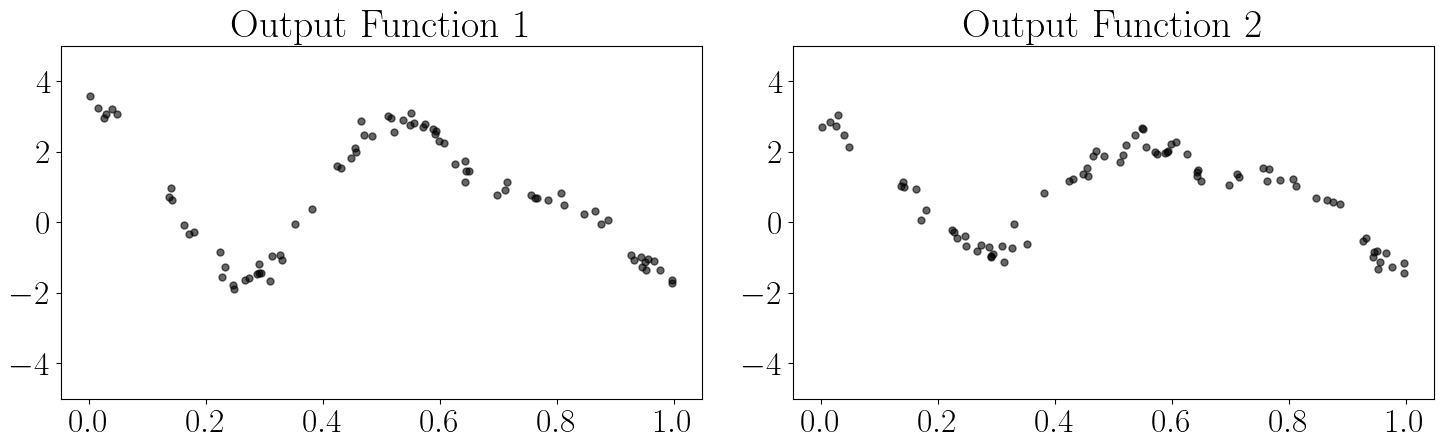

569
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


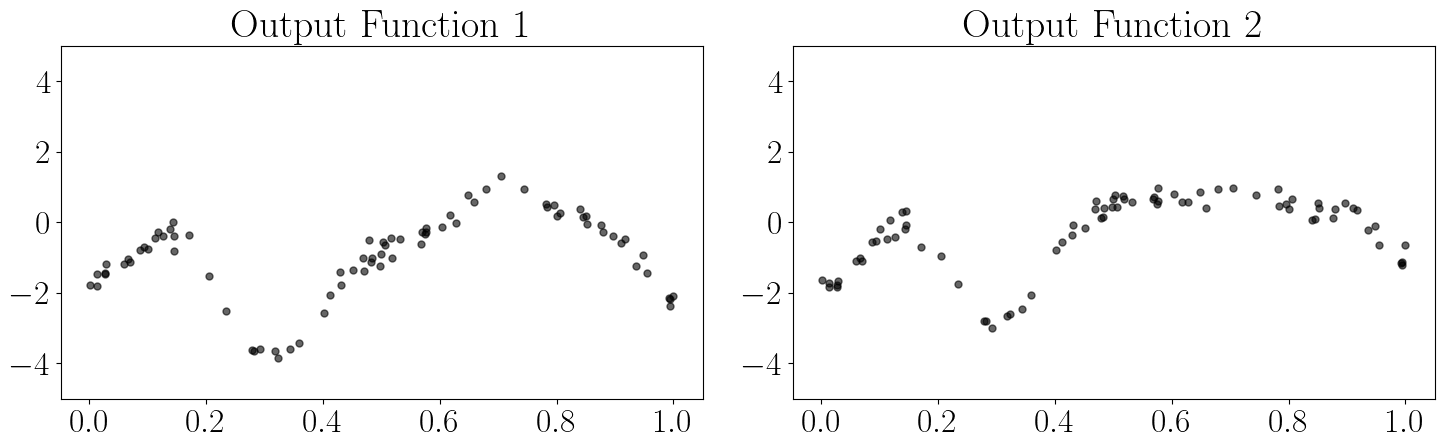

572
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


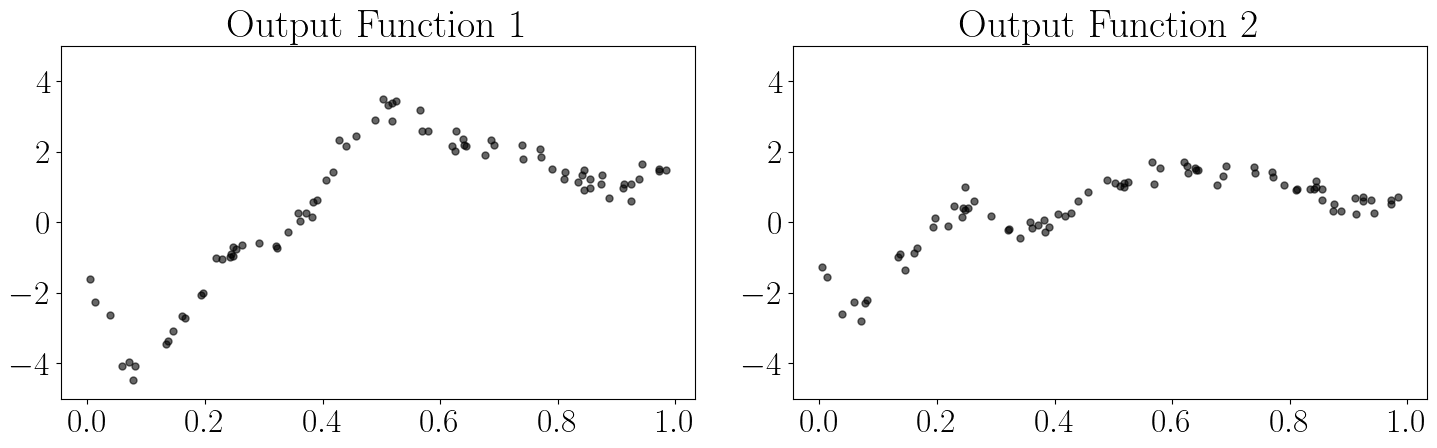

575
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


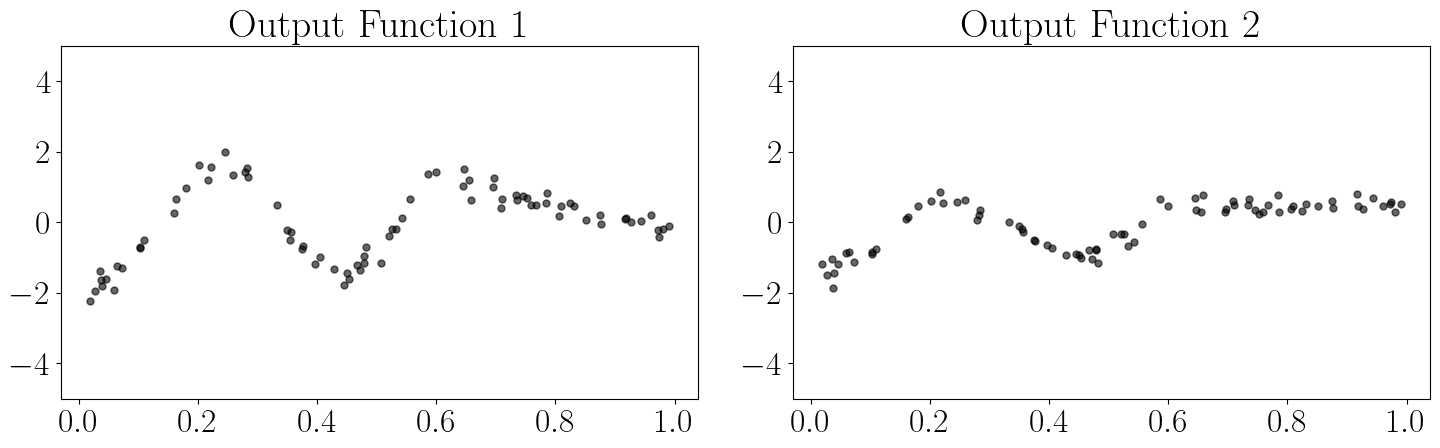

577
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


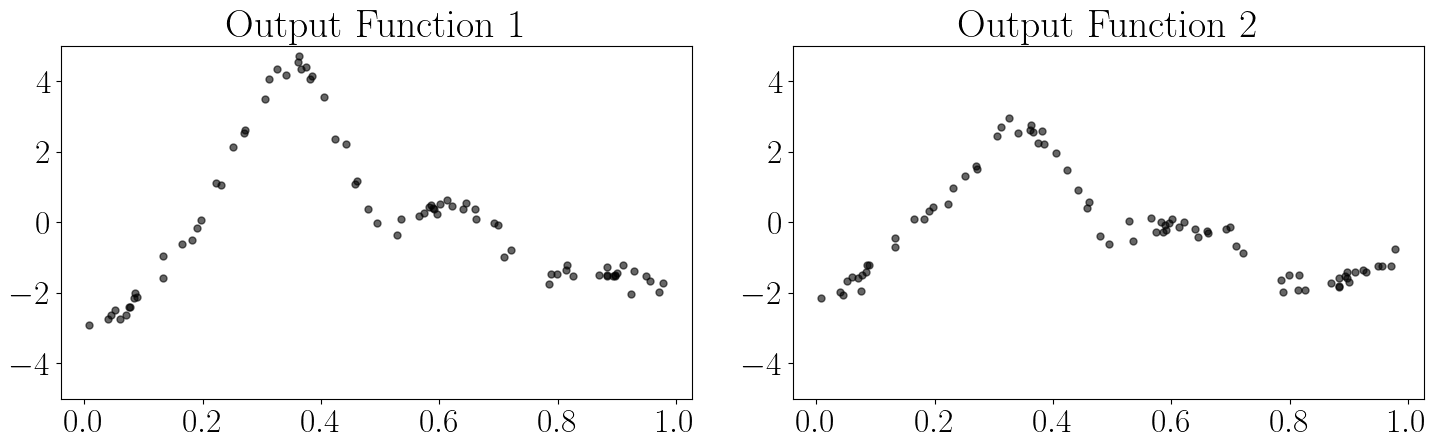

590
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


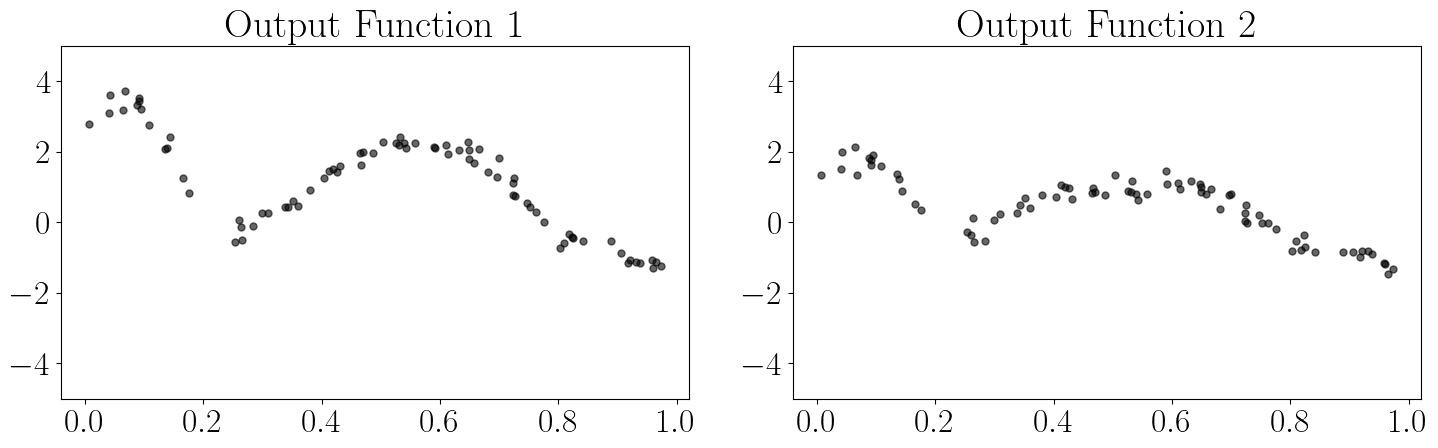

593
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


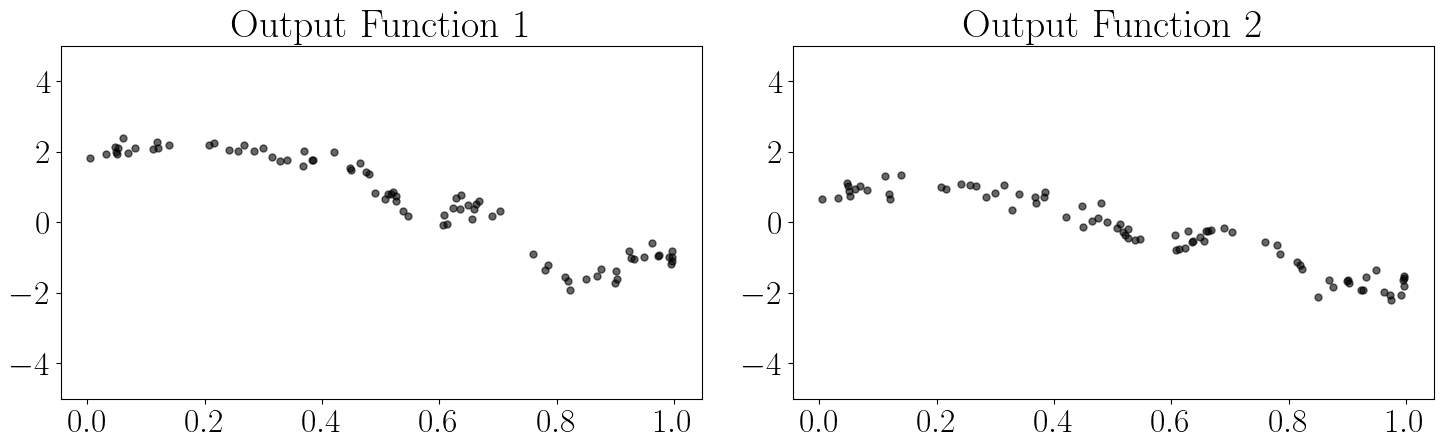

598
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


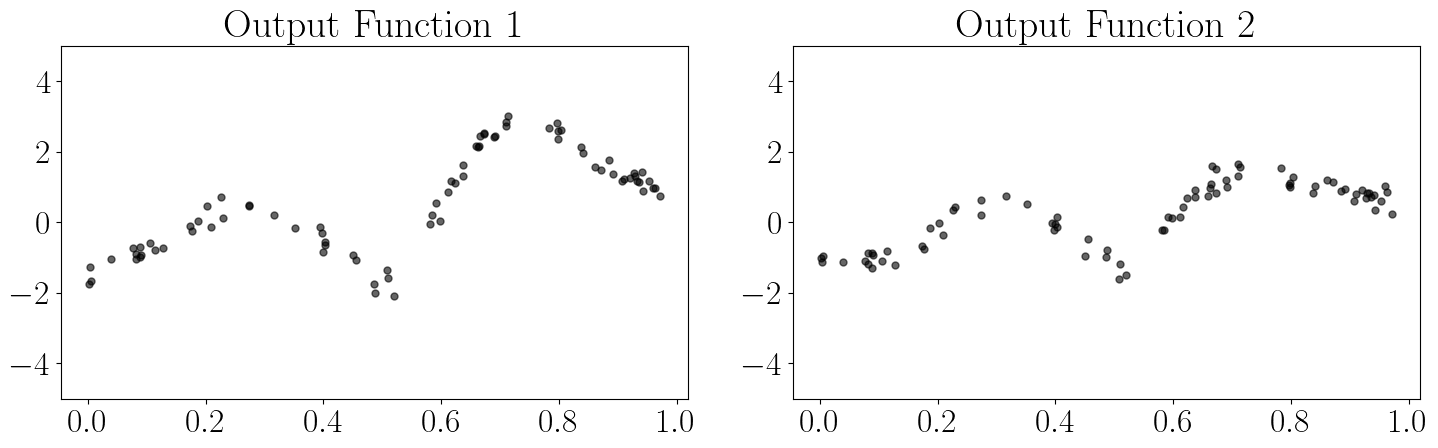

601
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


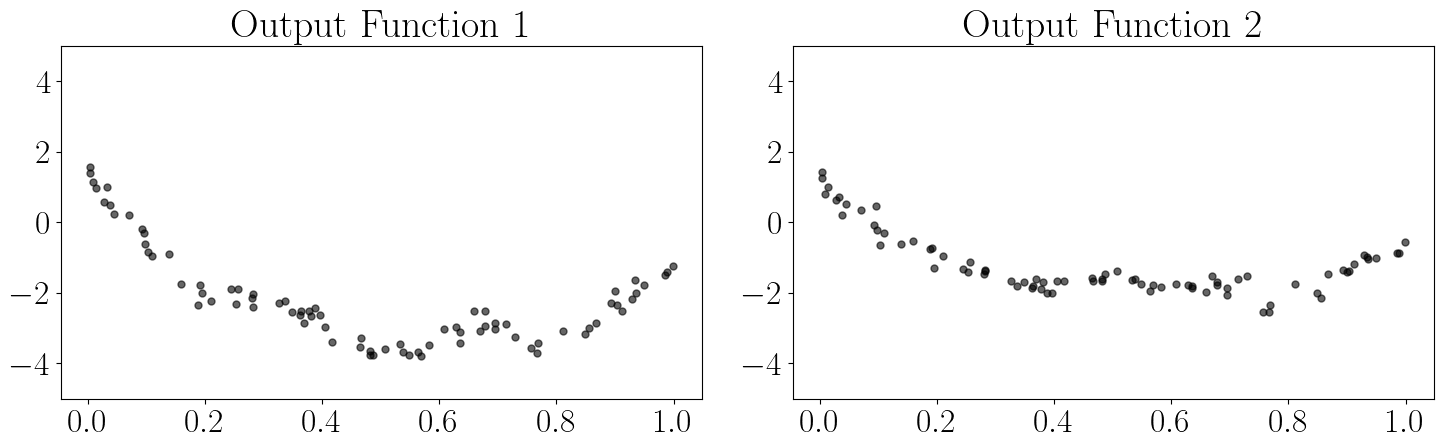

602
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


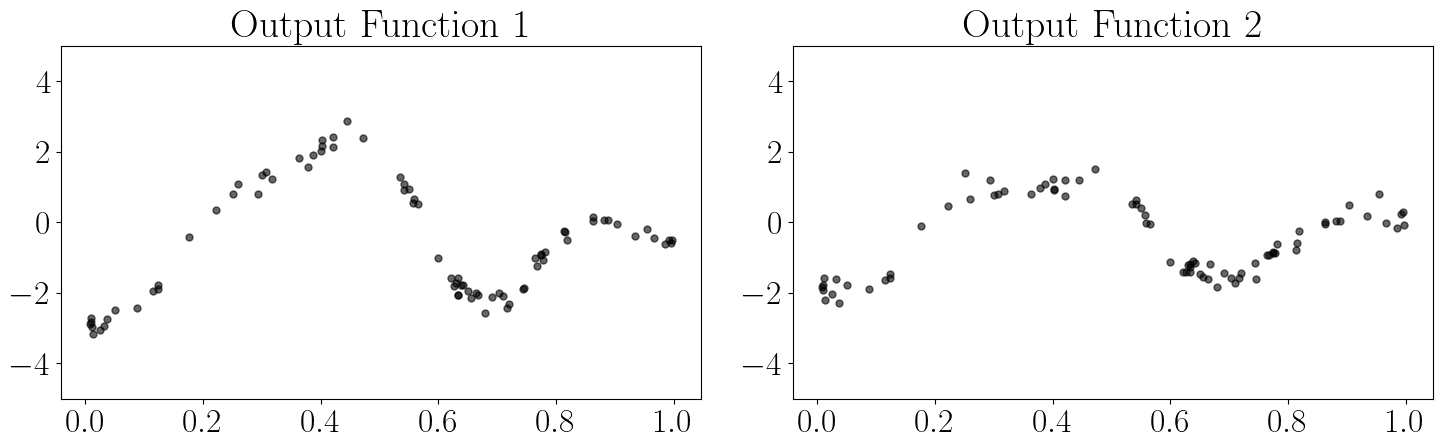

603
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


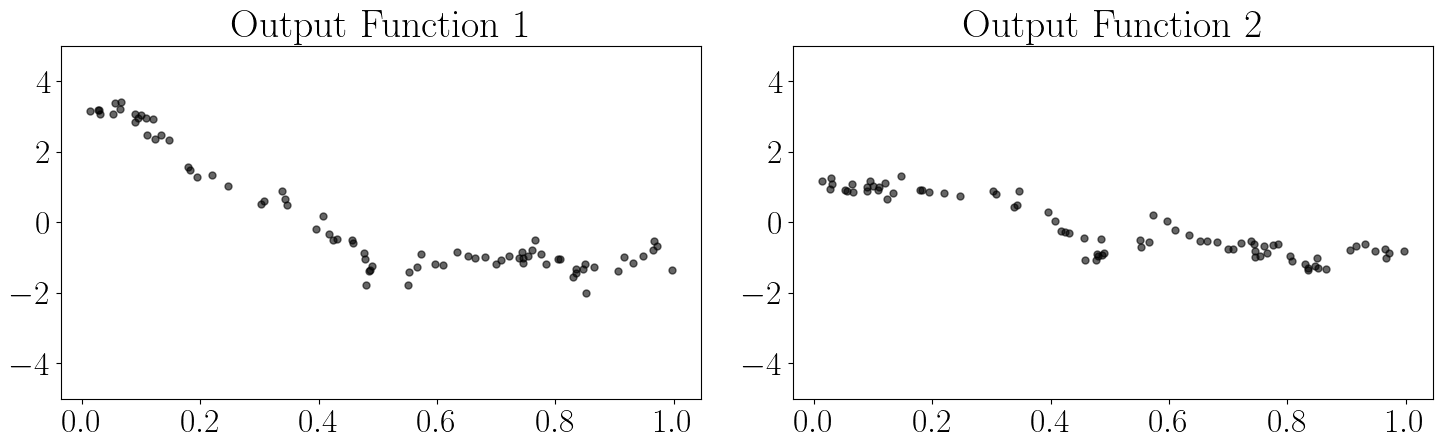

605
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


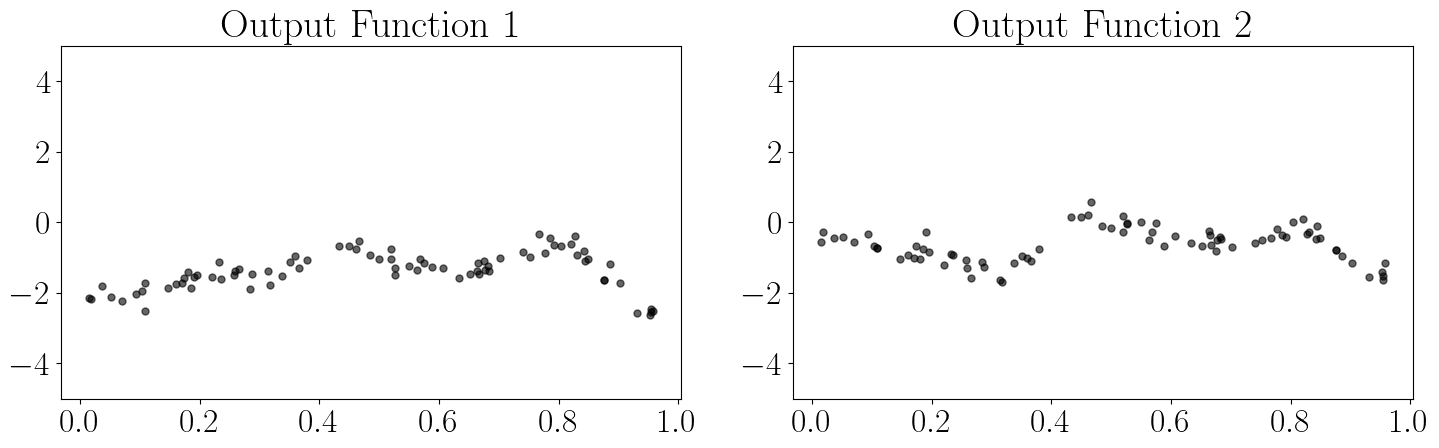

606
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


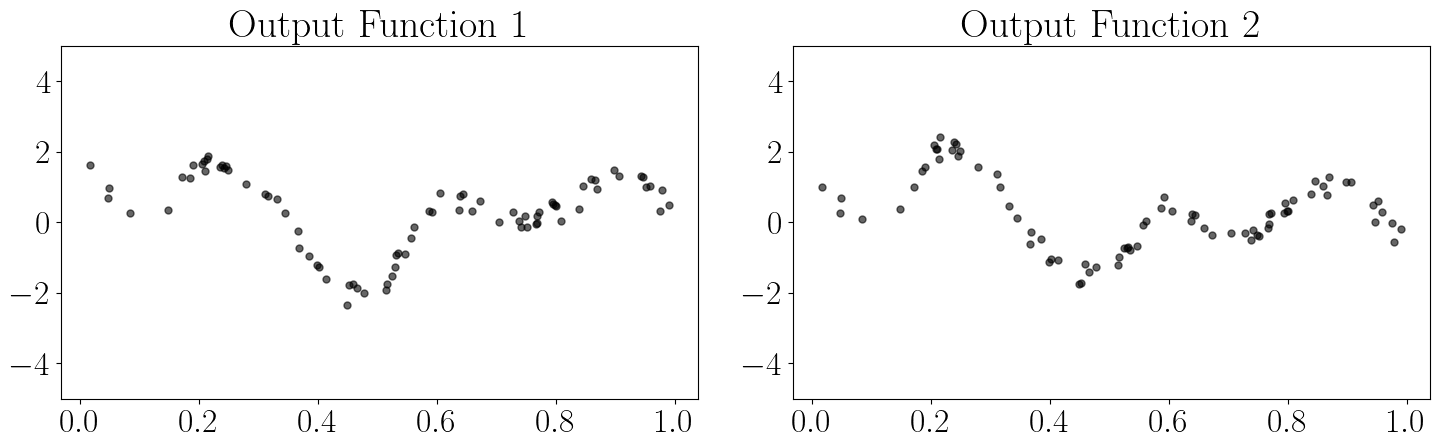

607
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


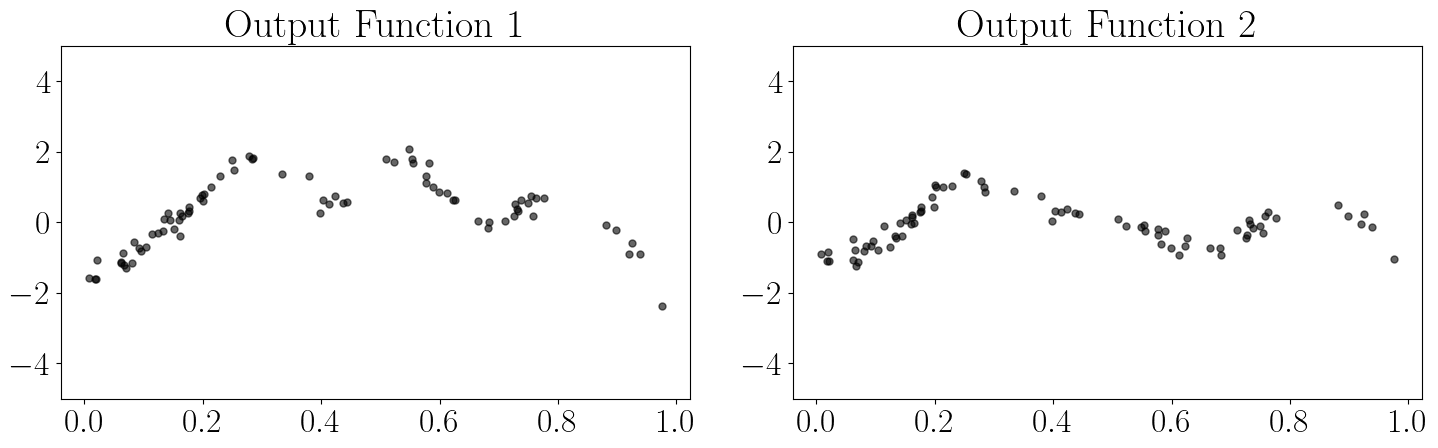

608
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


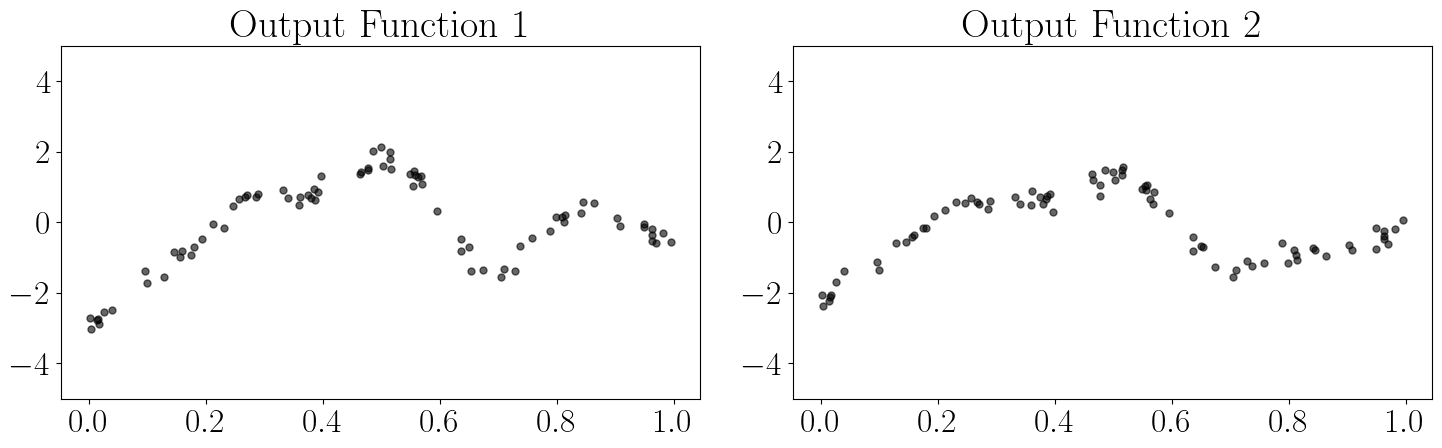

615
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


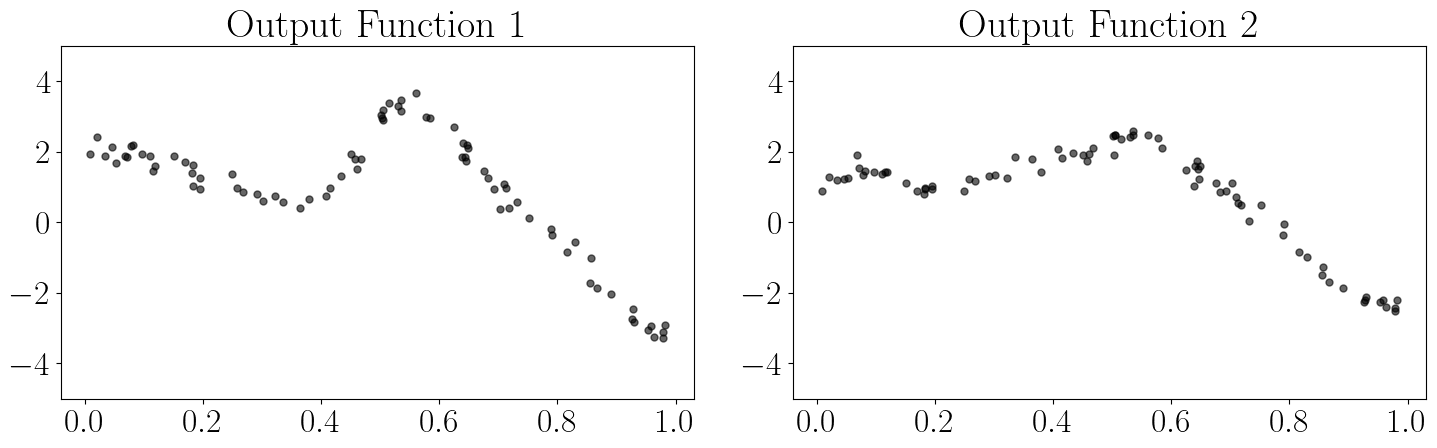

617
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


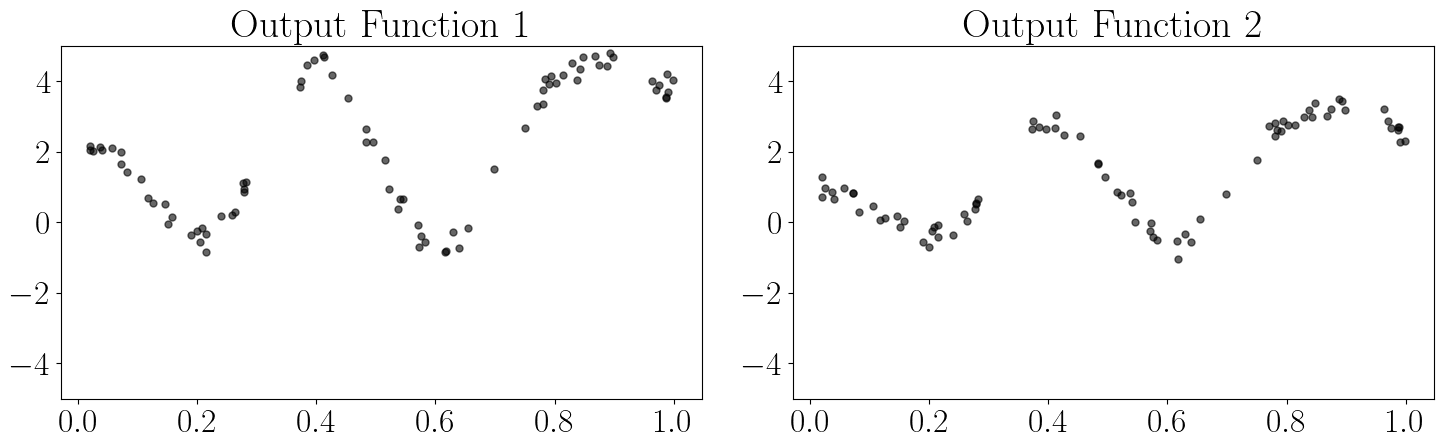

619
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


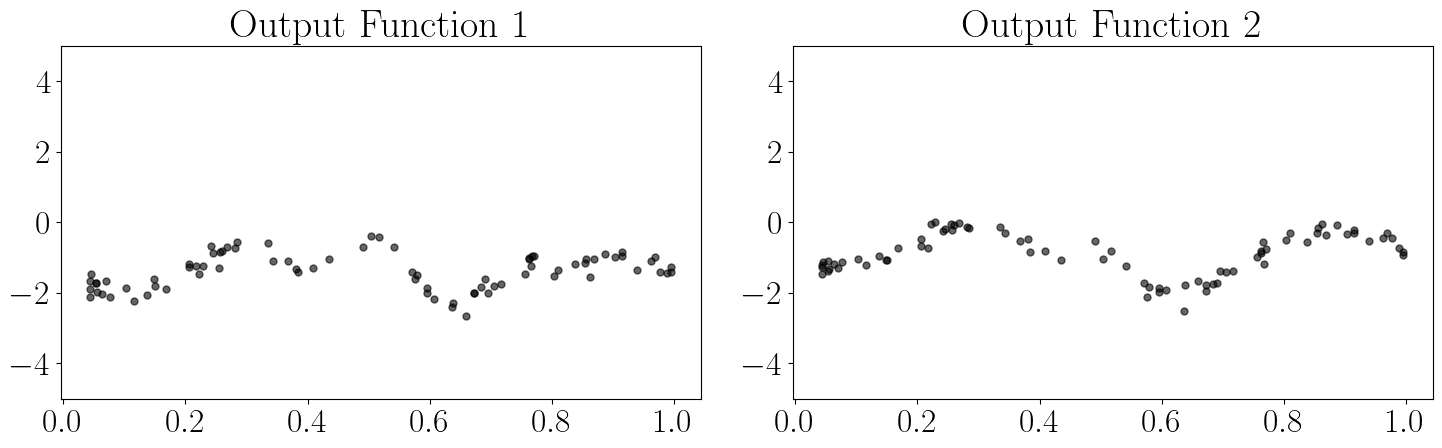

620
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


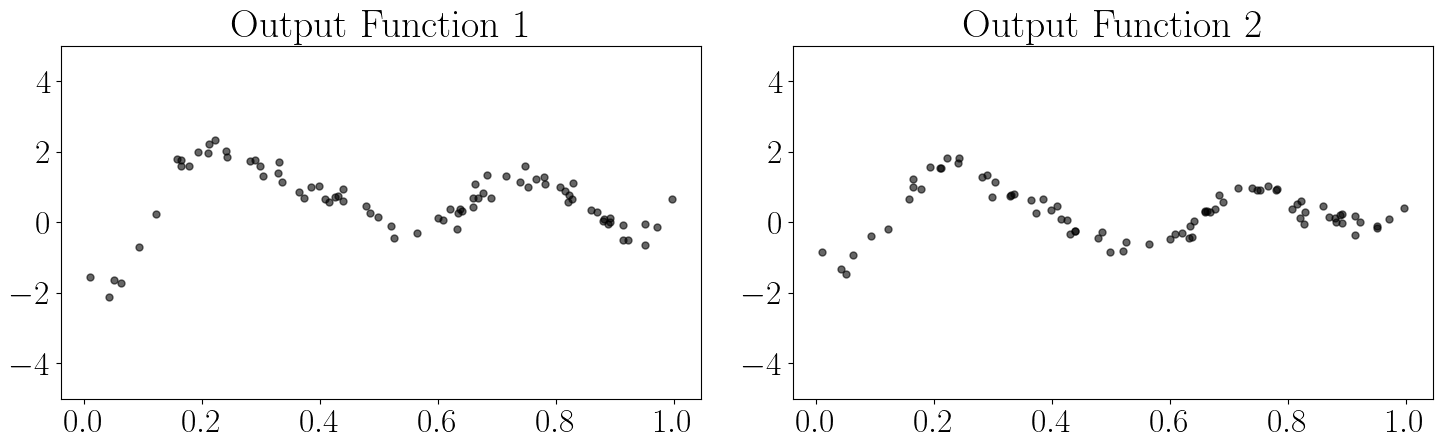

622
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


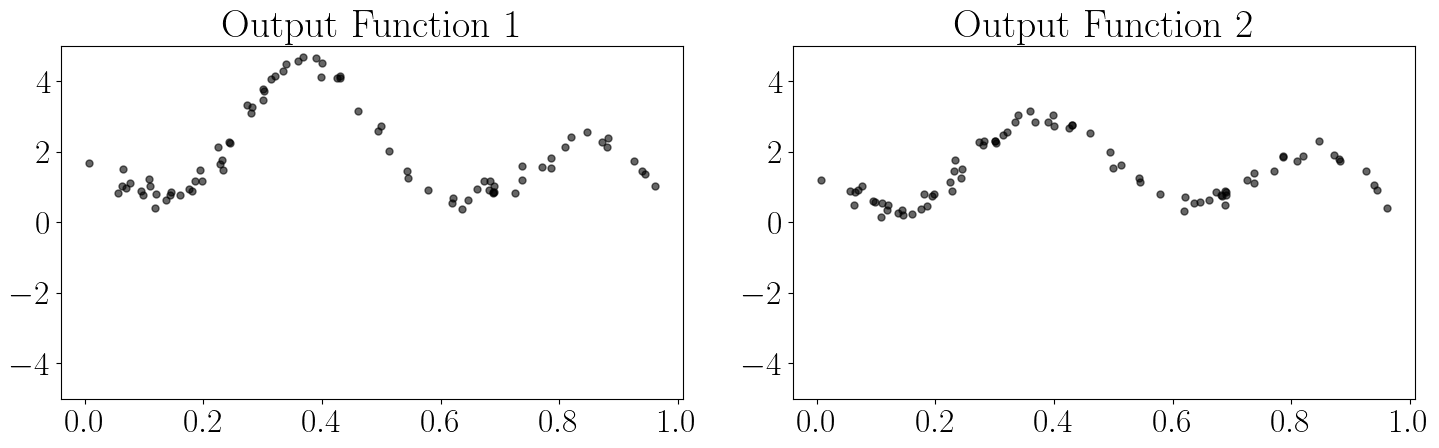

625
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


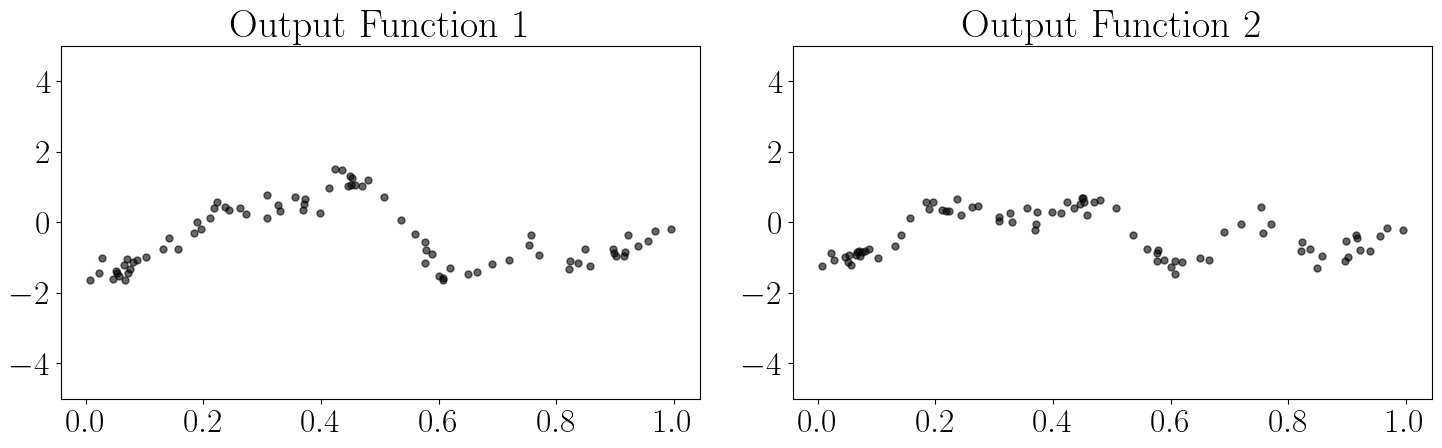

630
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


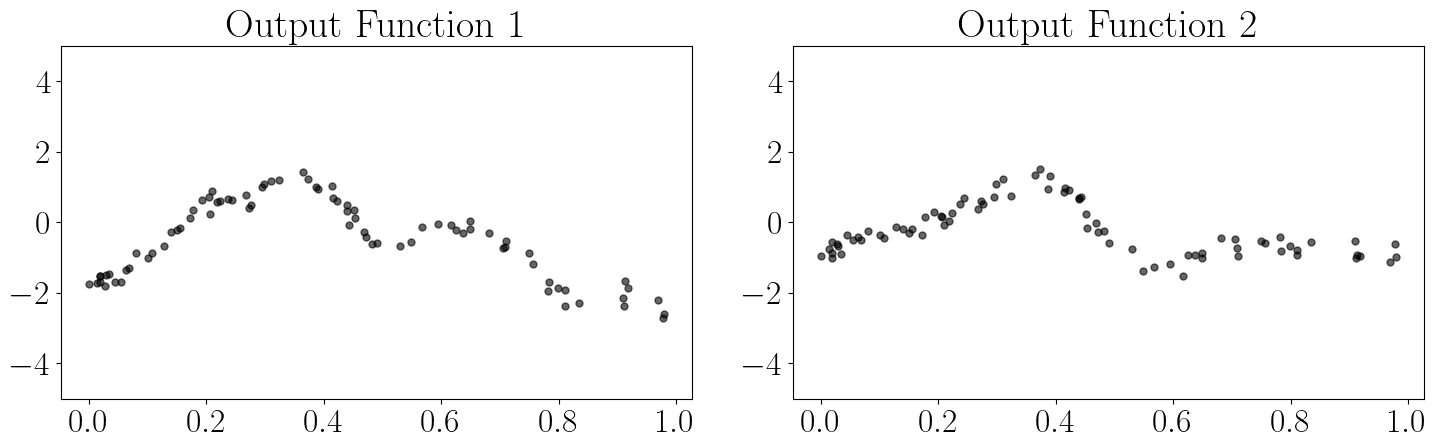

632
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


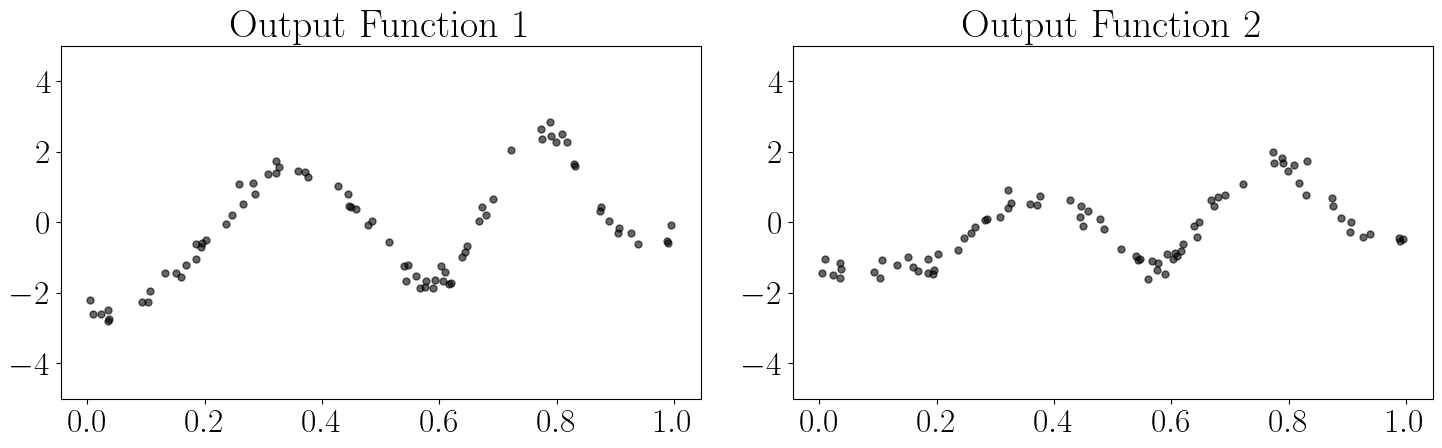

634
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


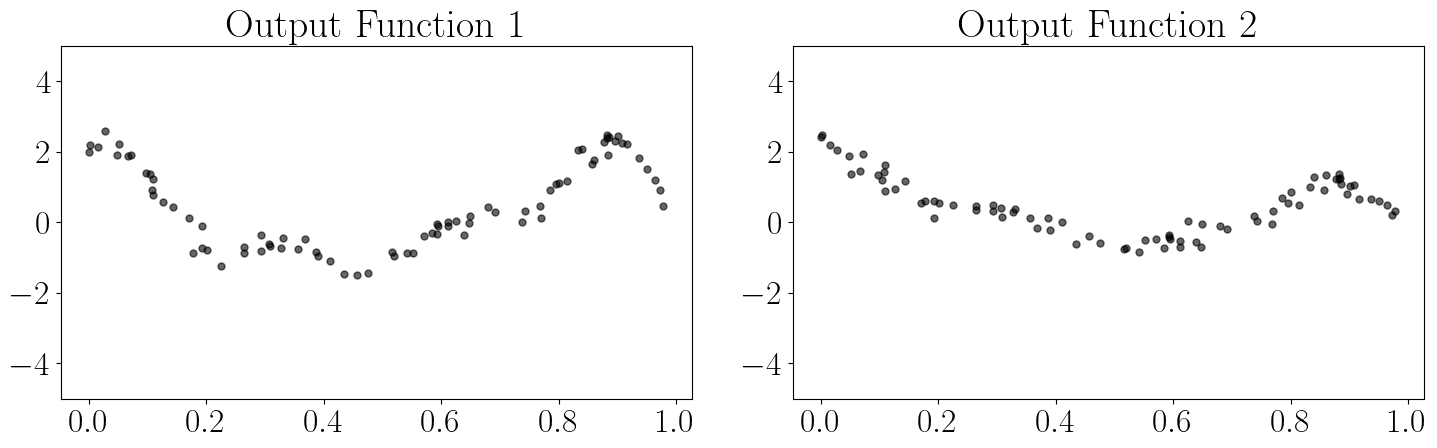

635
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


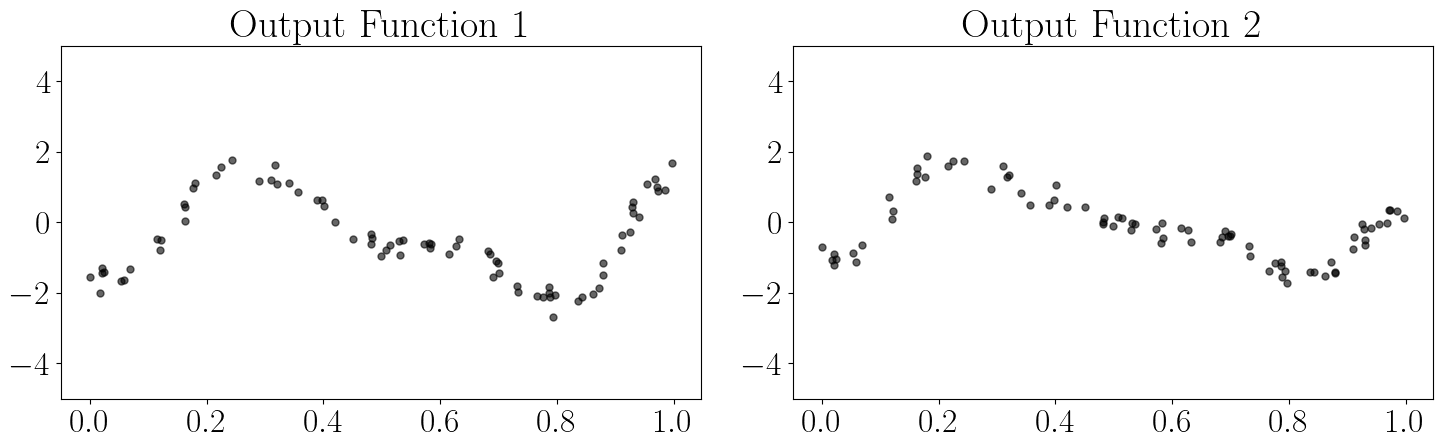

636
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


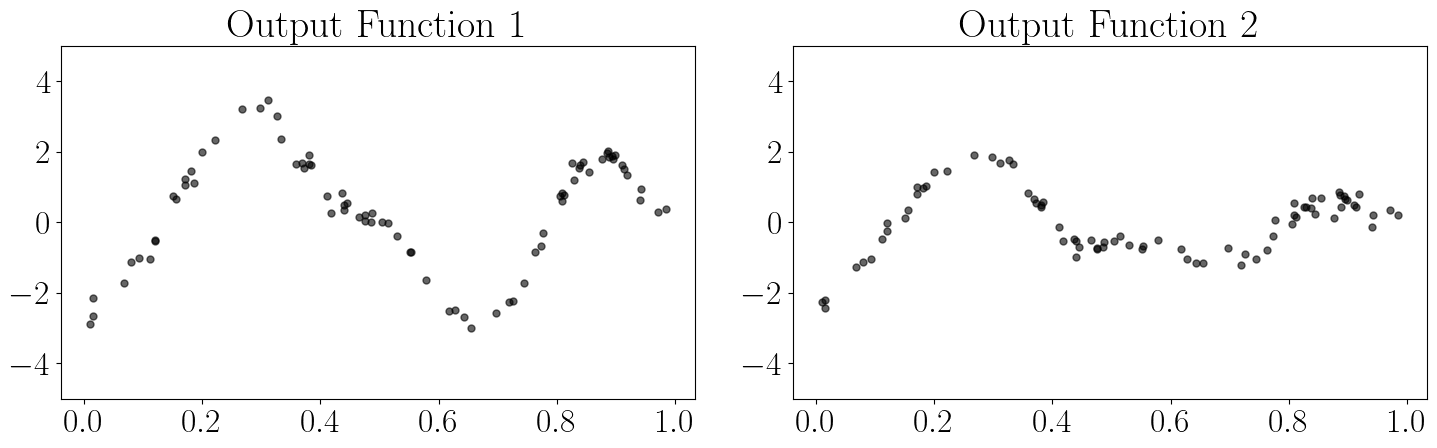

637
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


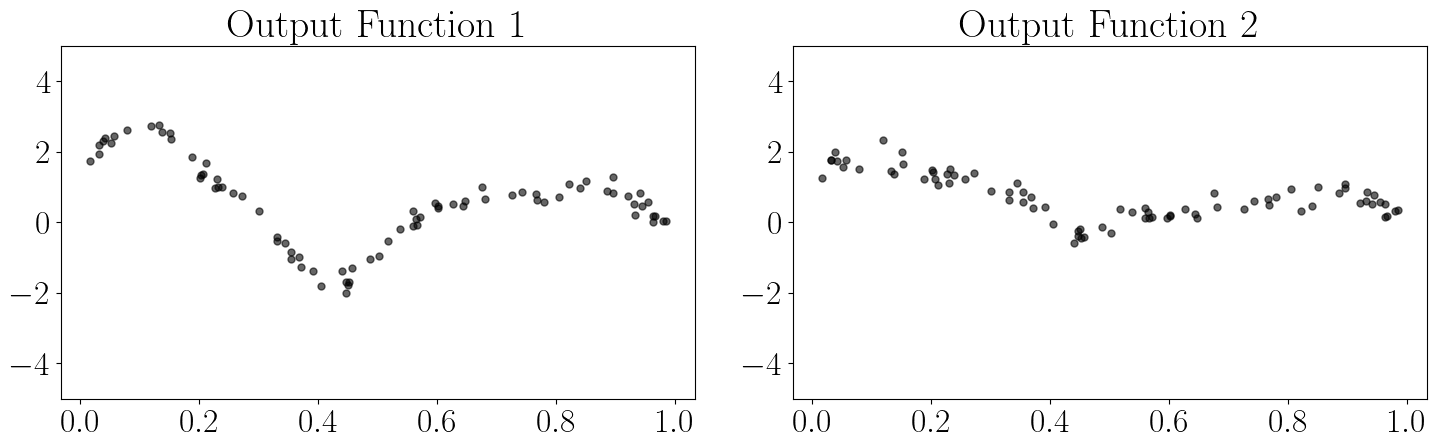

641
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


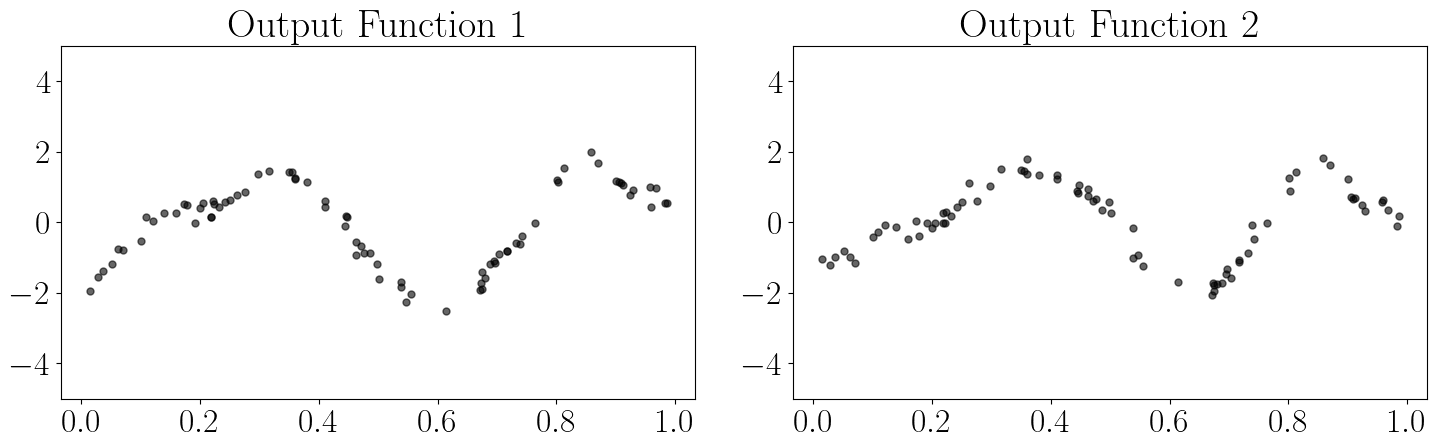

642
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


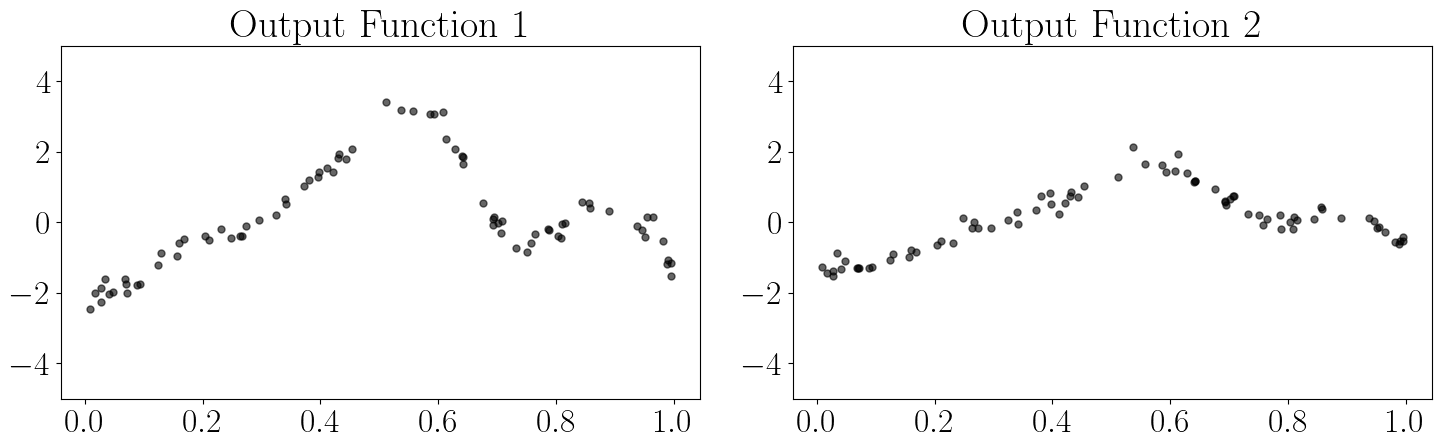

644
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


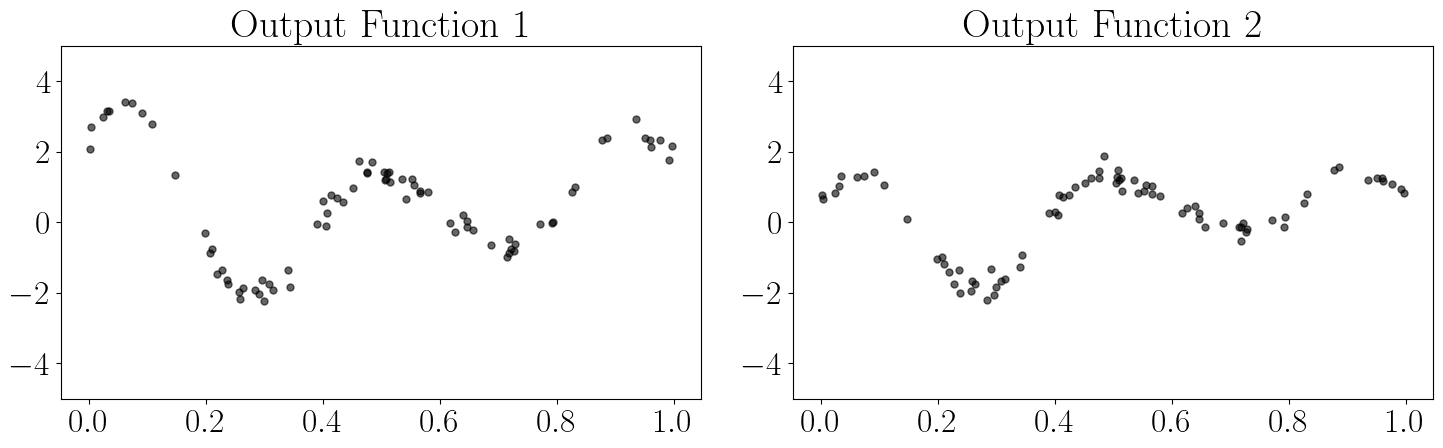

646
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


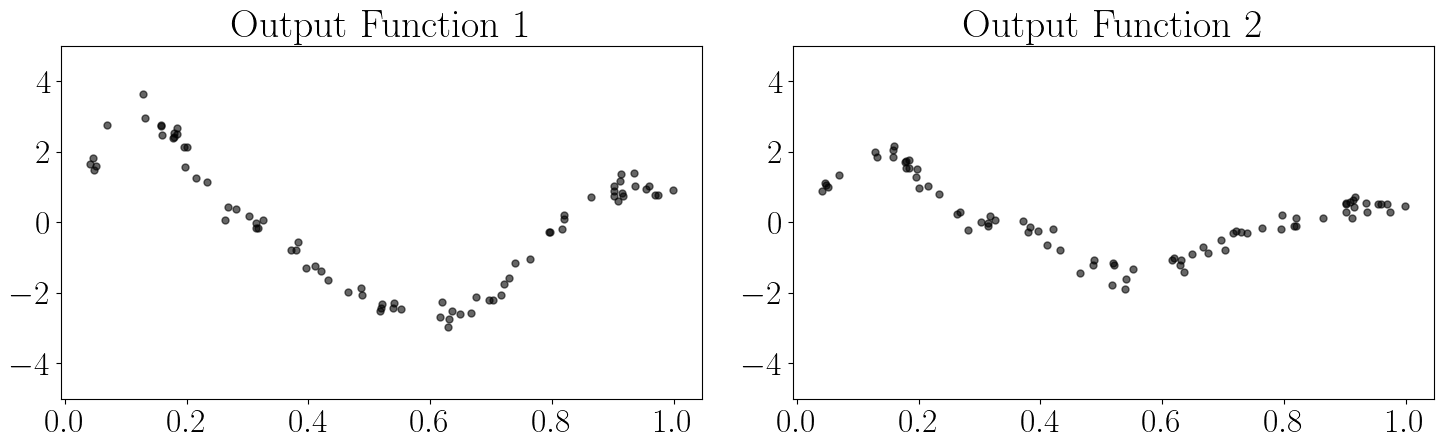

652
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


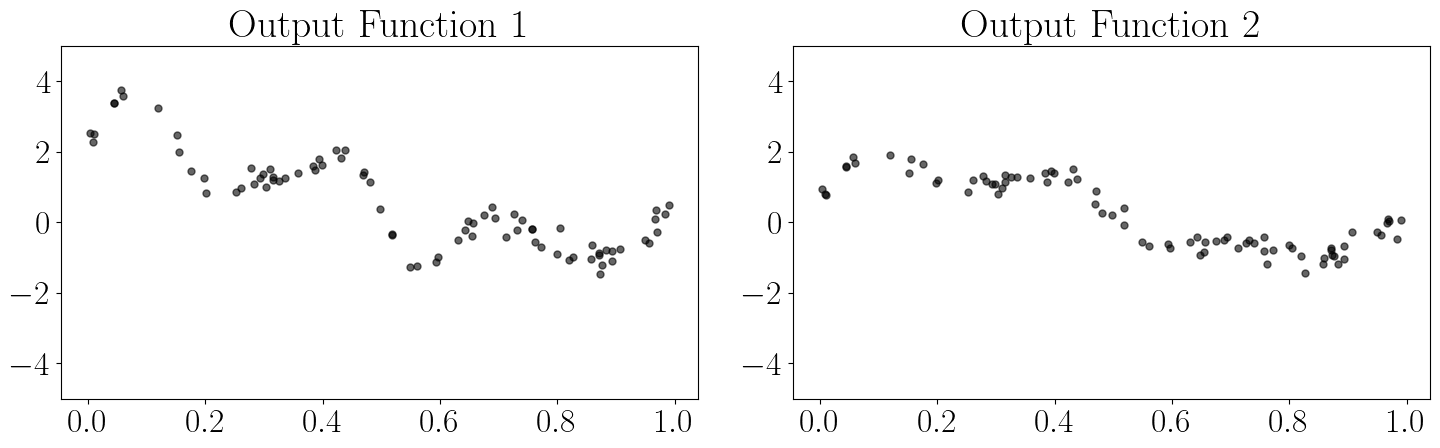

657
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


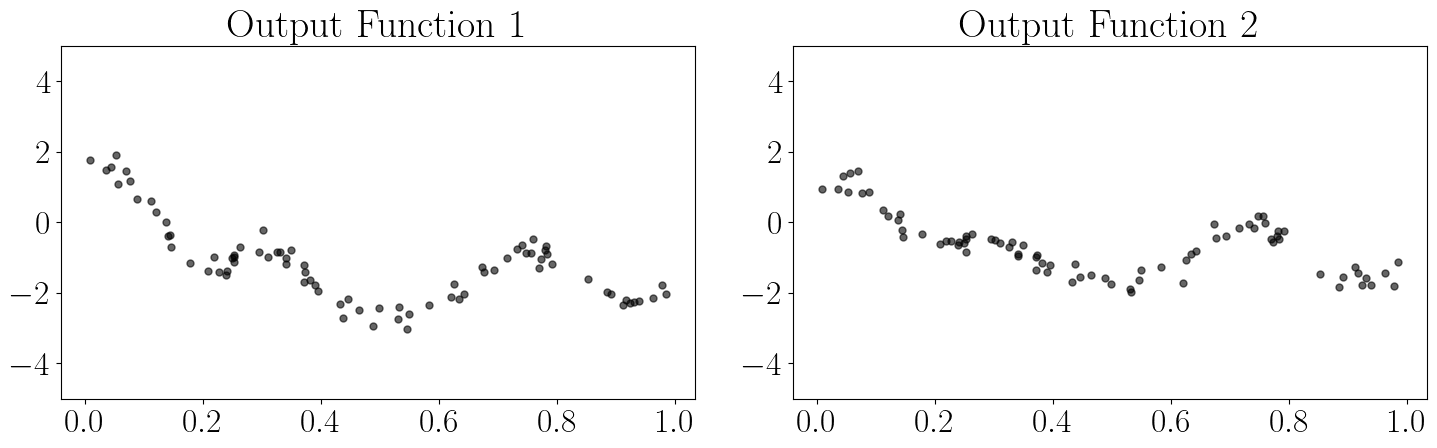

663
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


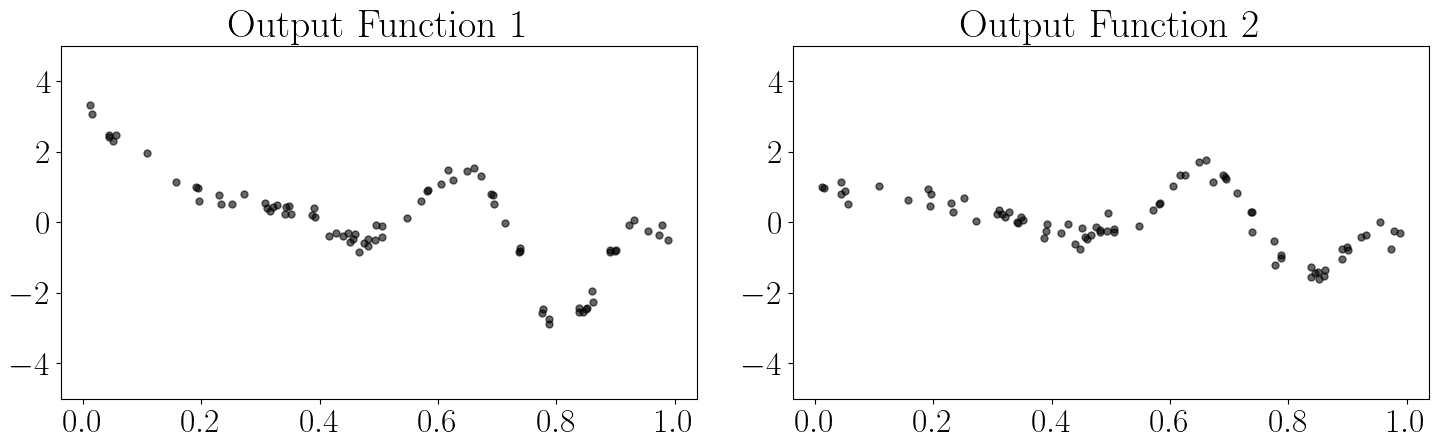

664
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


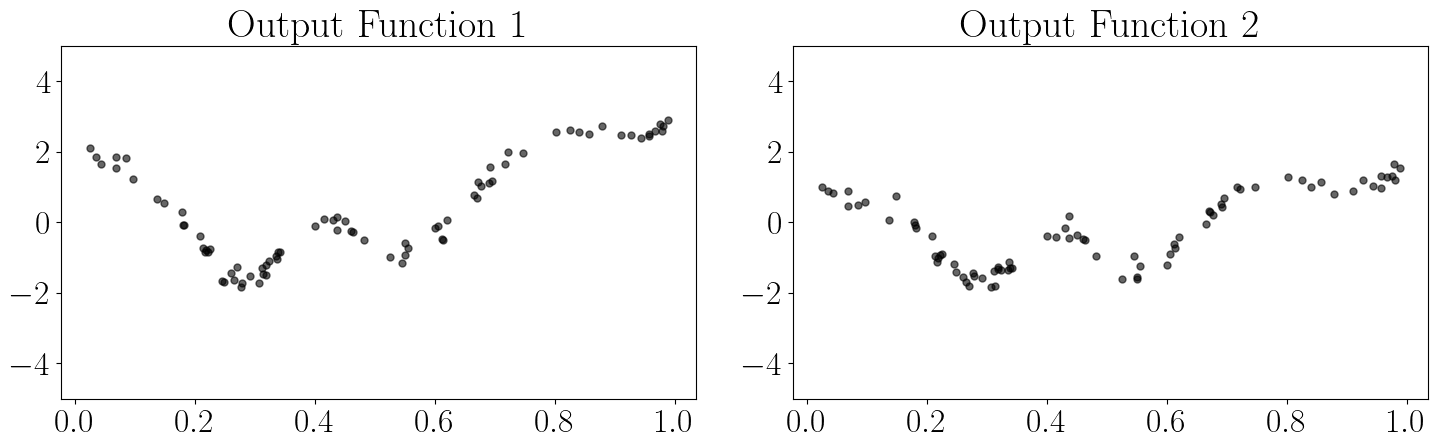

669
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


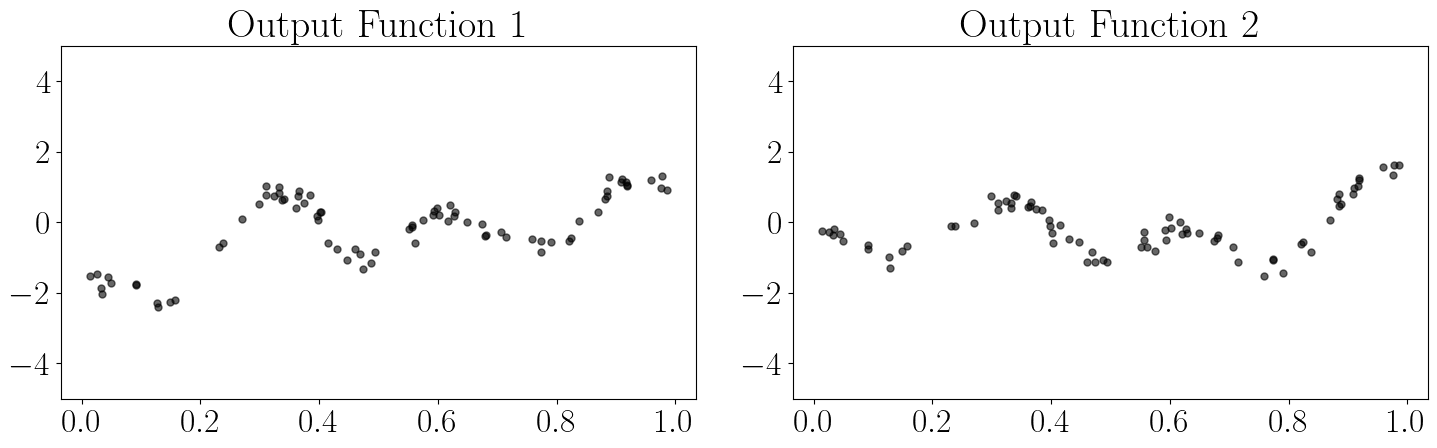

671
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


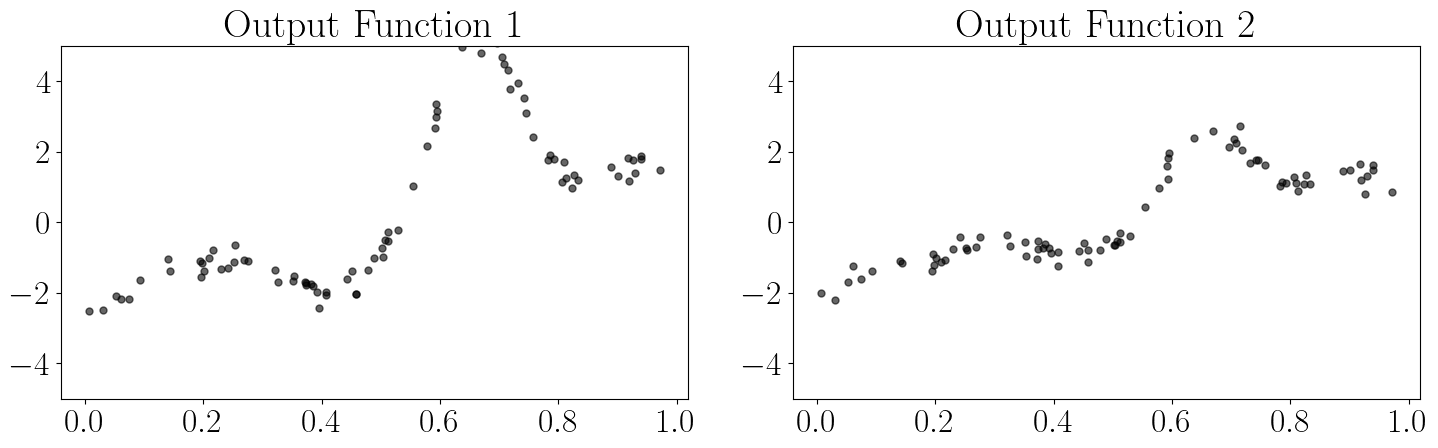

673
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


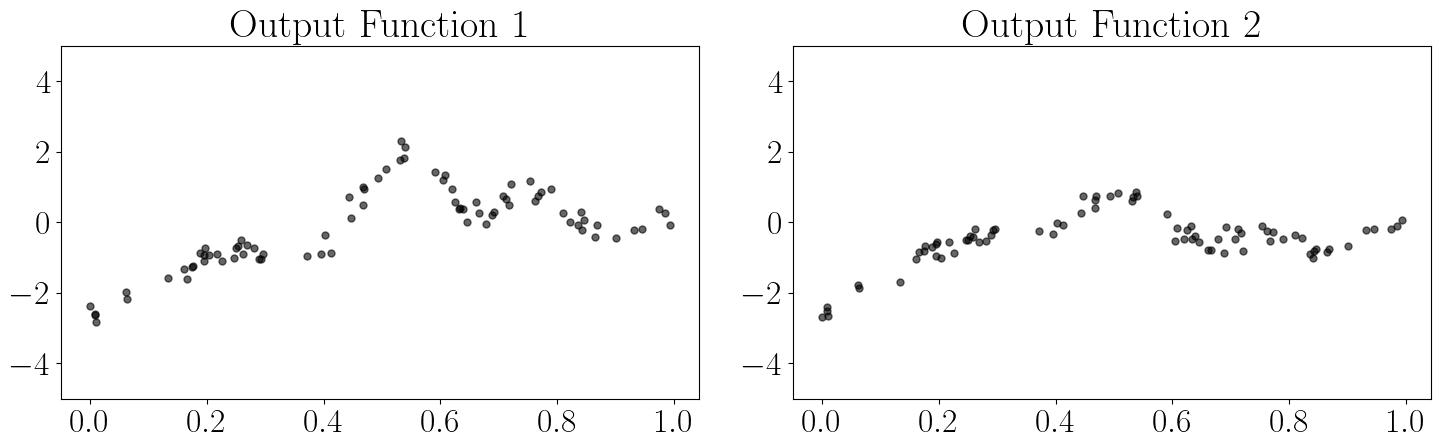

675
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


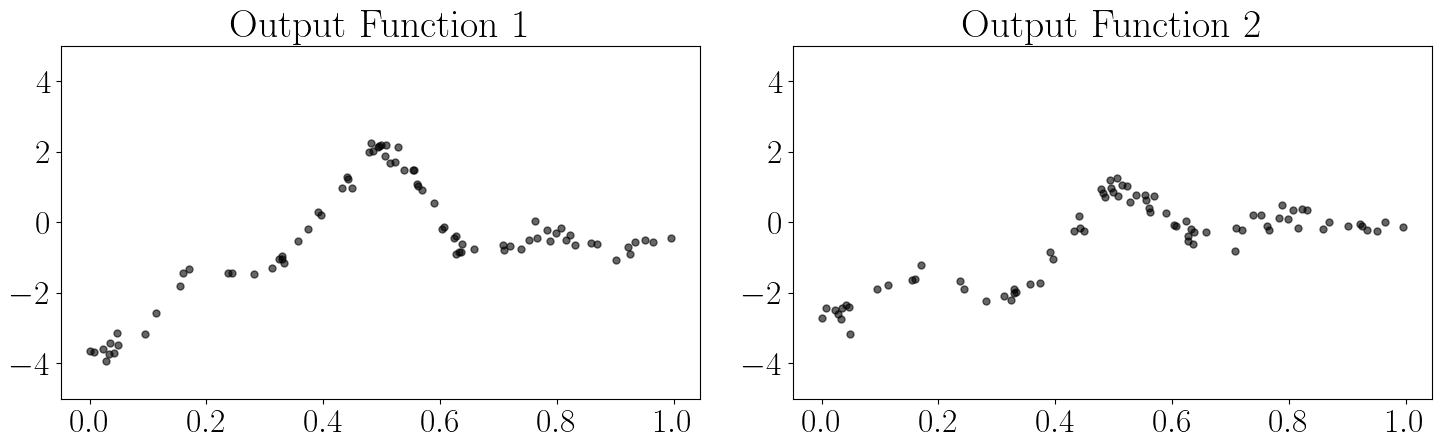

676
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


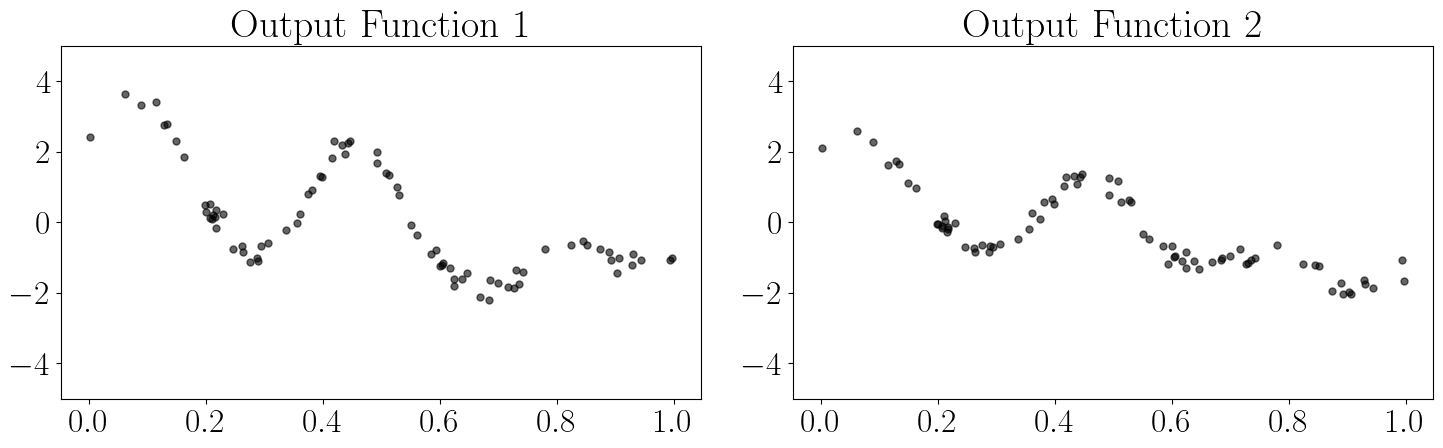

679
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


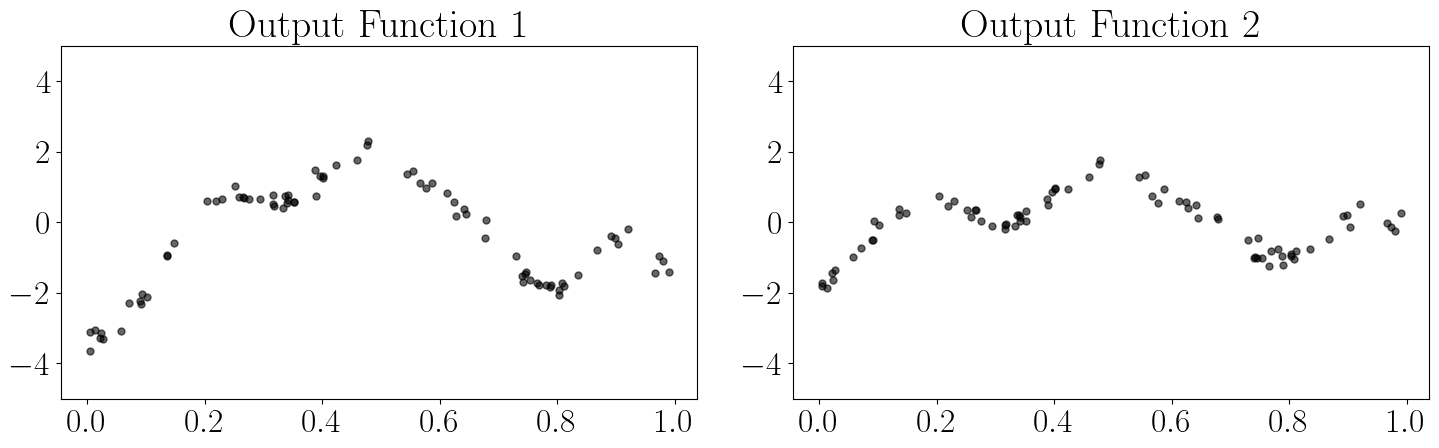

684
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


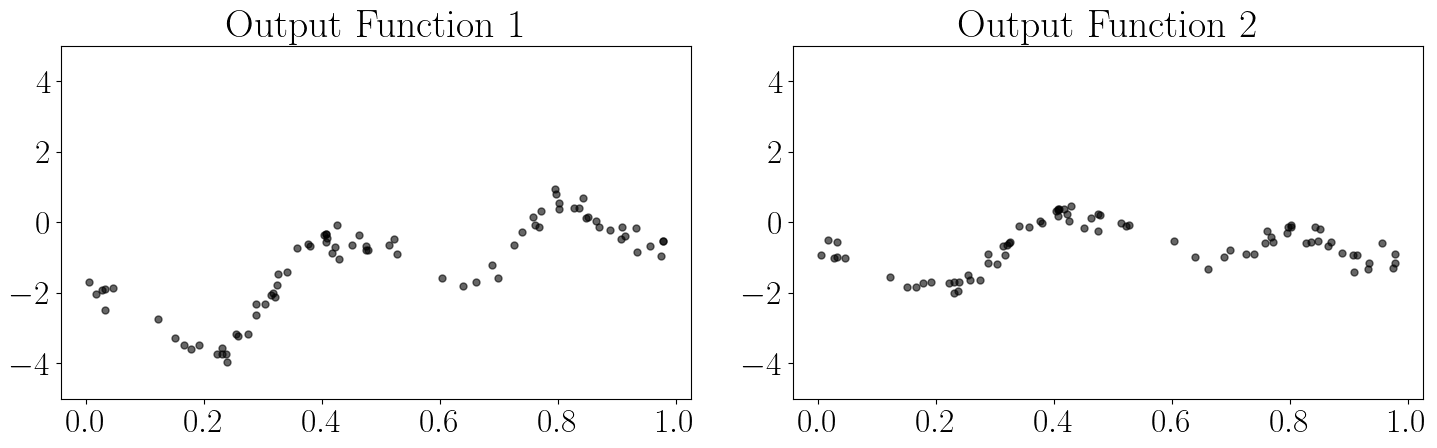

686
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


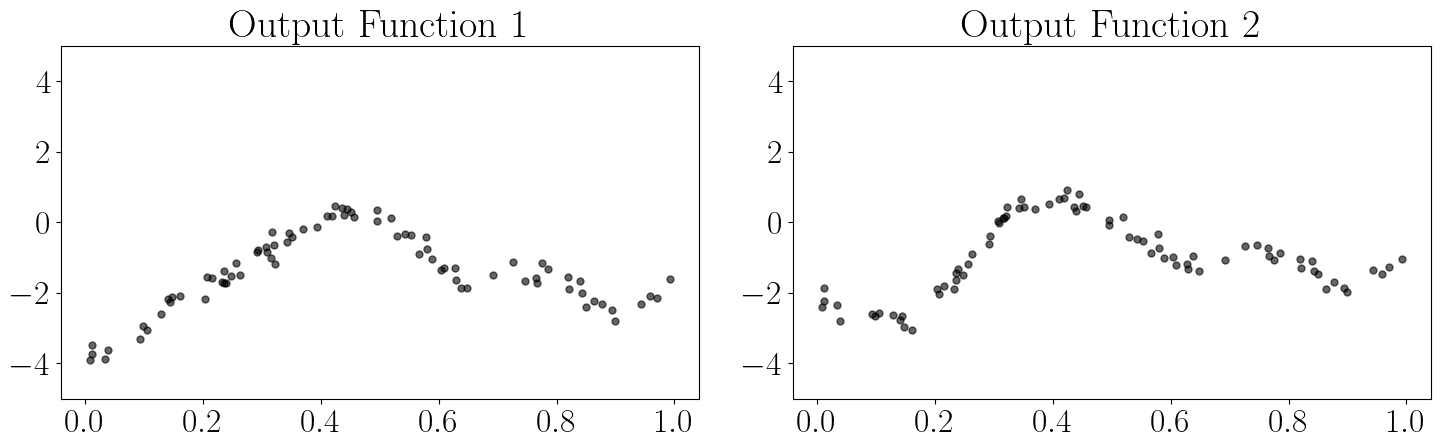

687
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


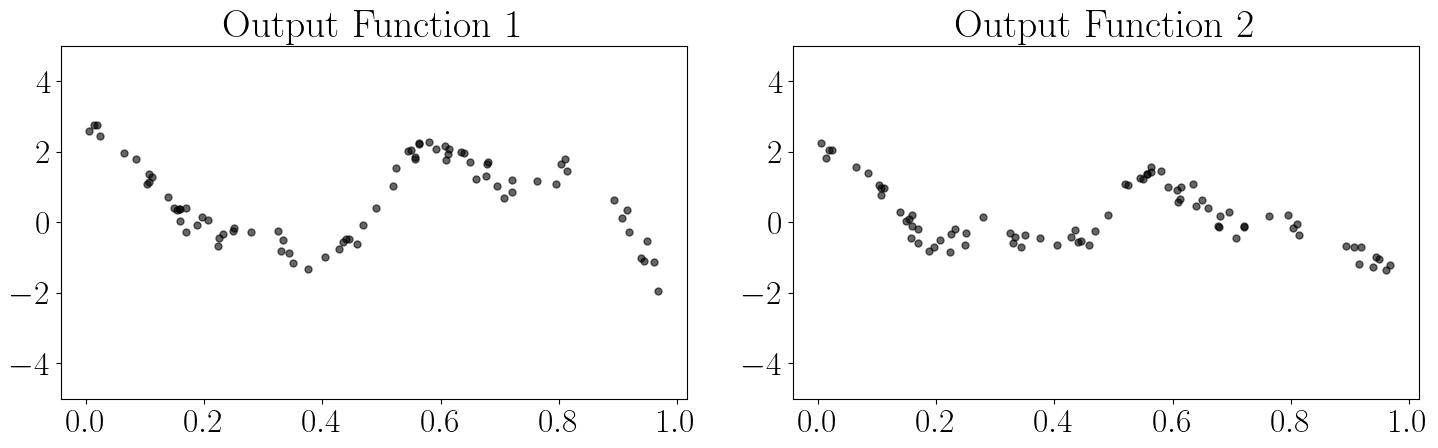

690
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


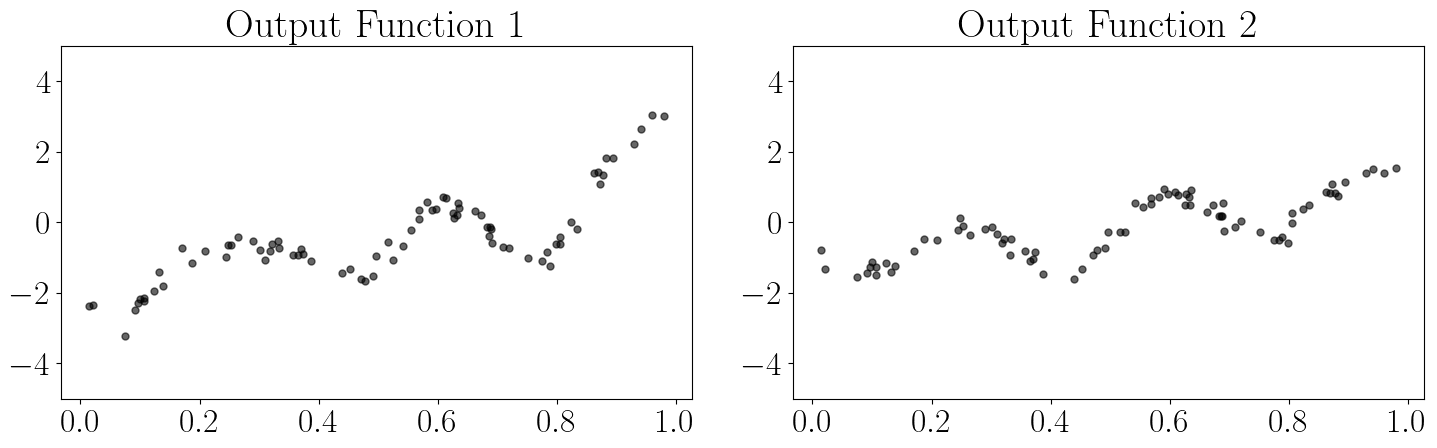

692
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


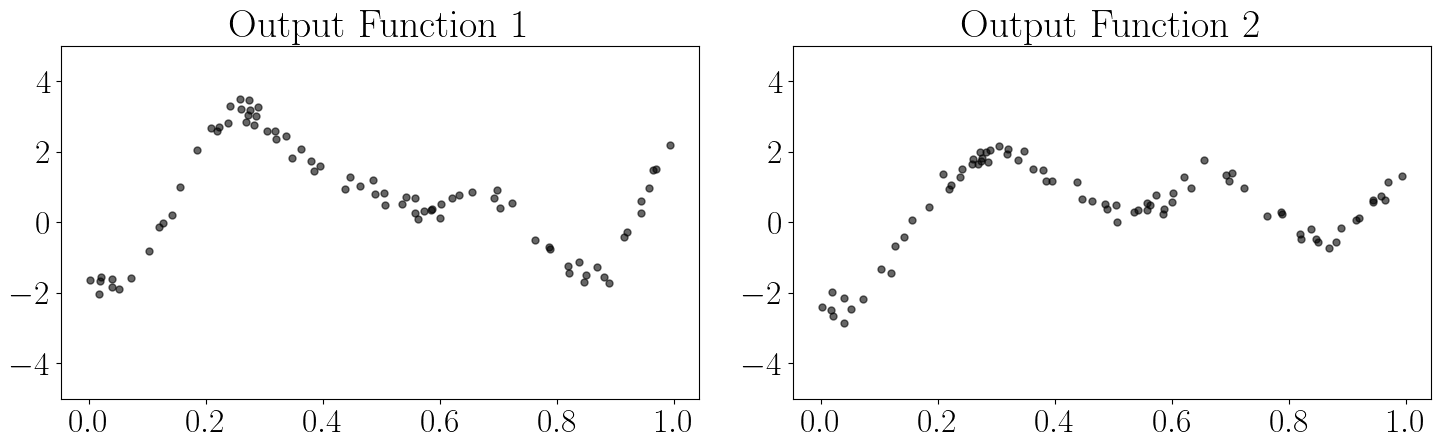

696
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


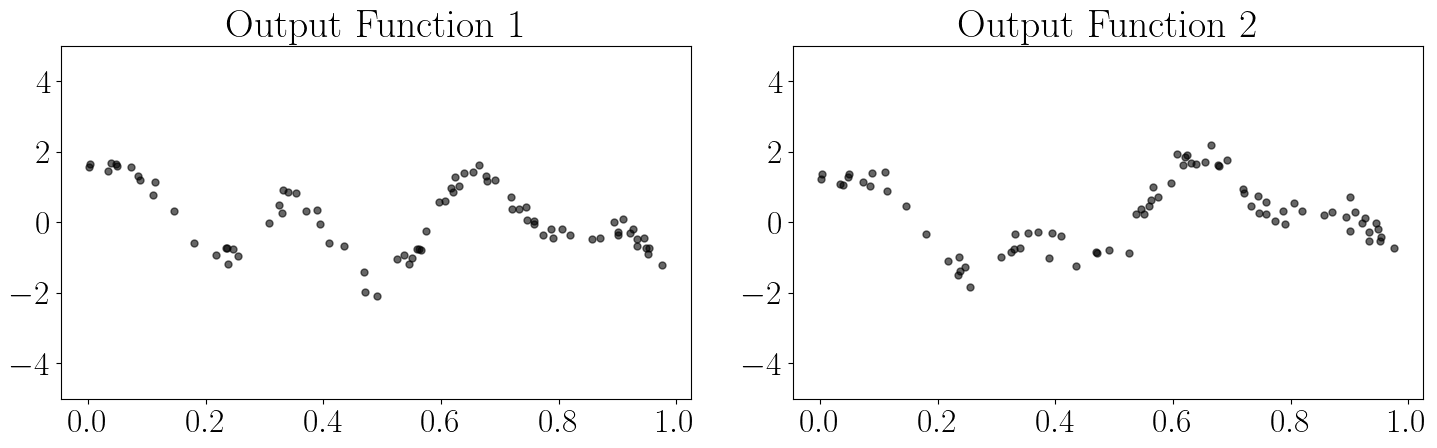

706
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


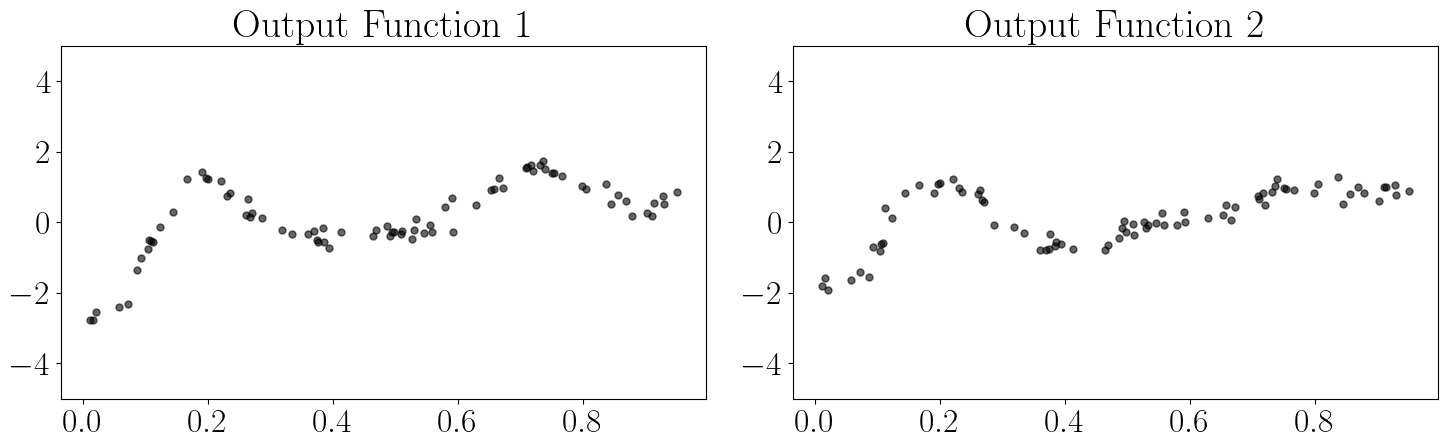

715
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


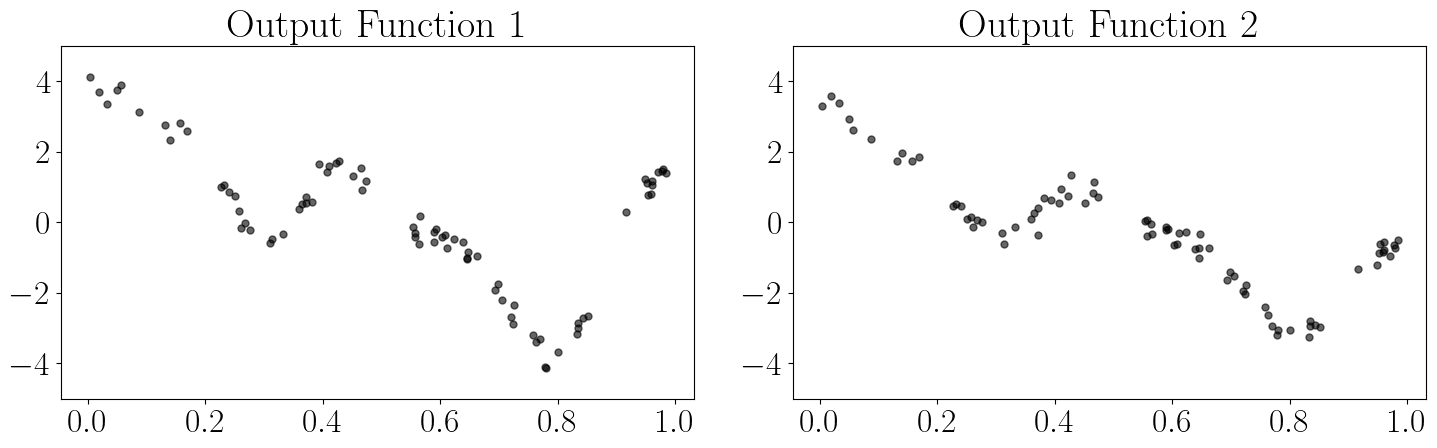

717
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


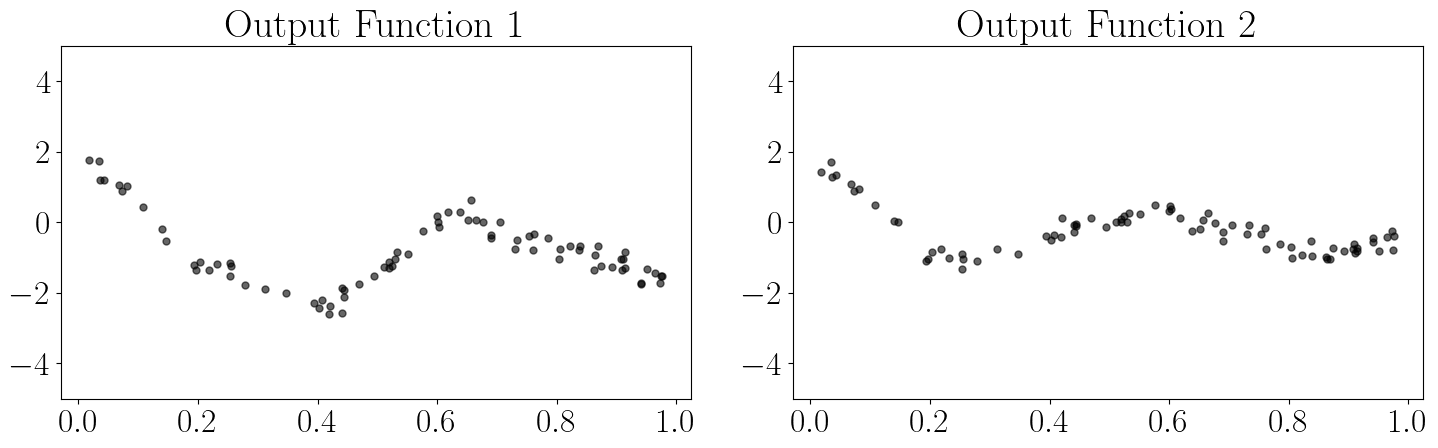

727
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


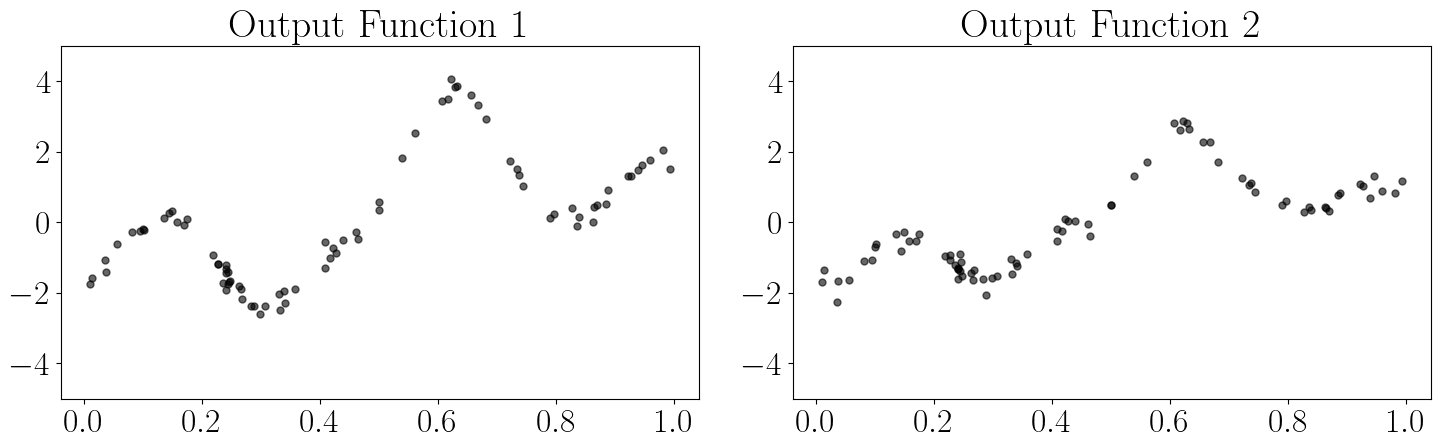

731
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


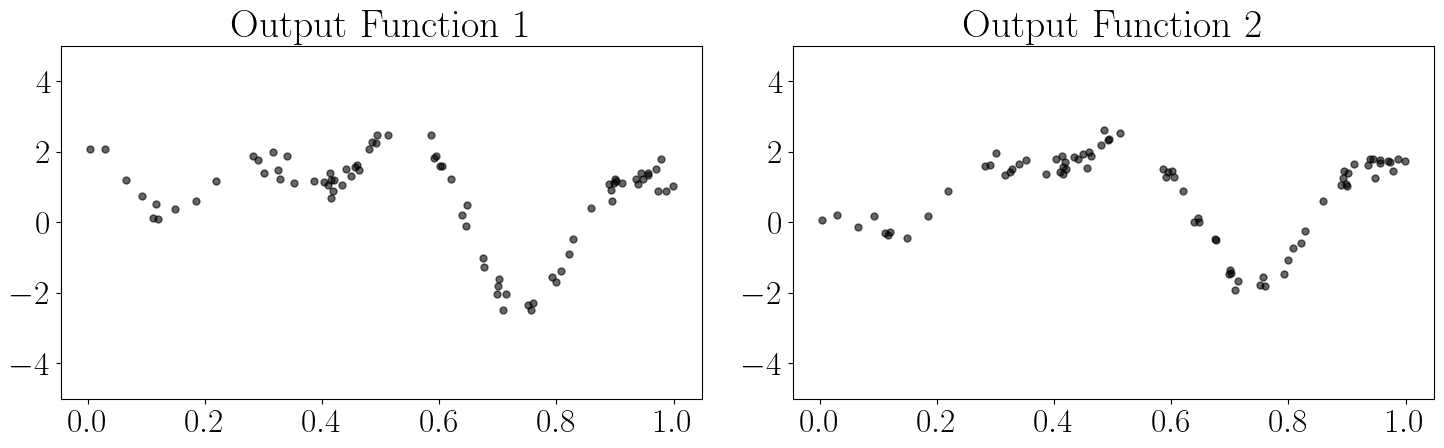

735
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


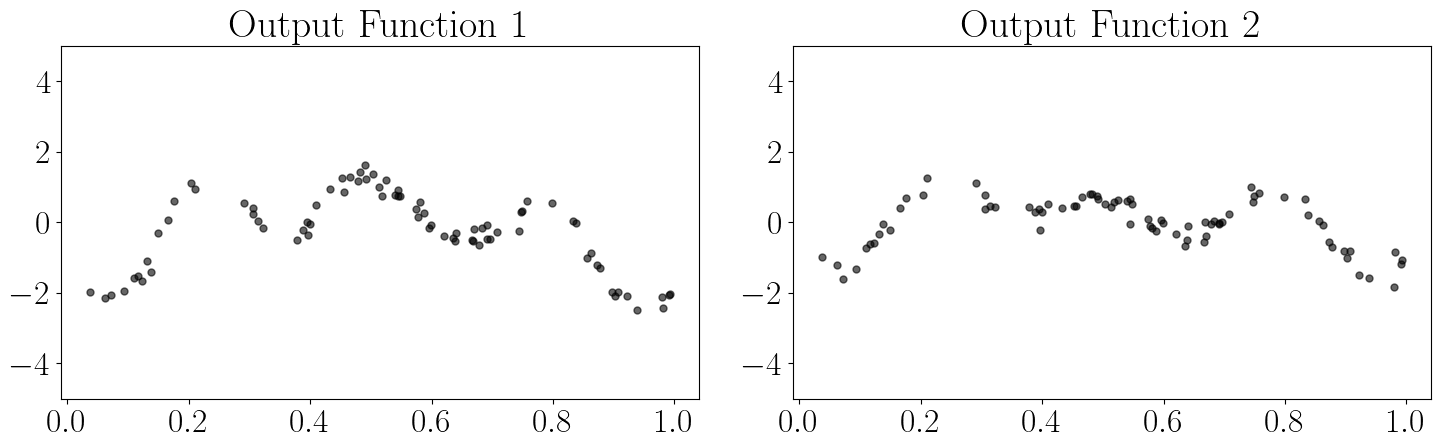

736
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


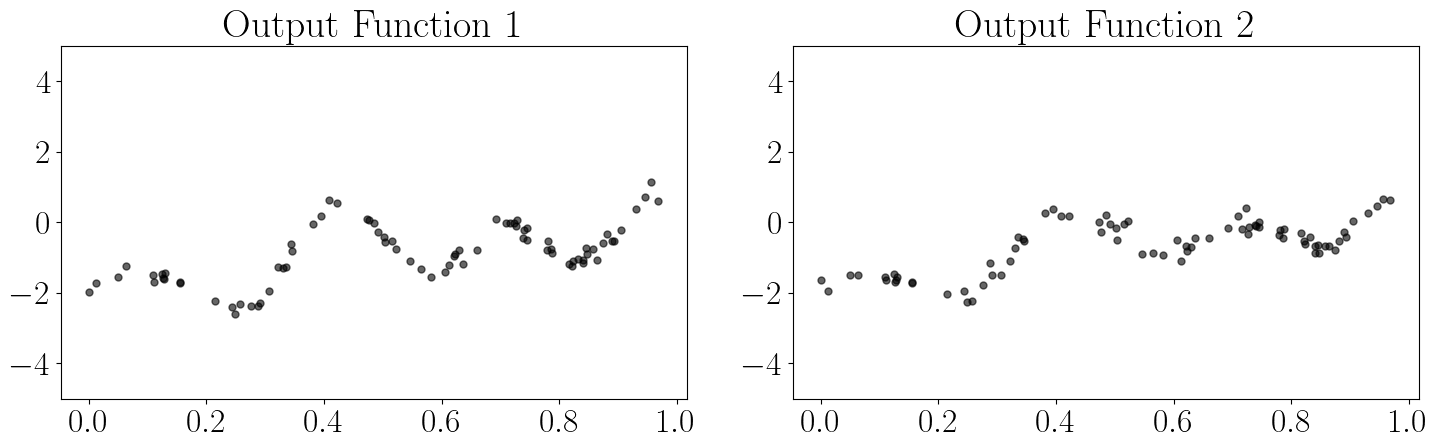

739
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


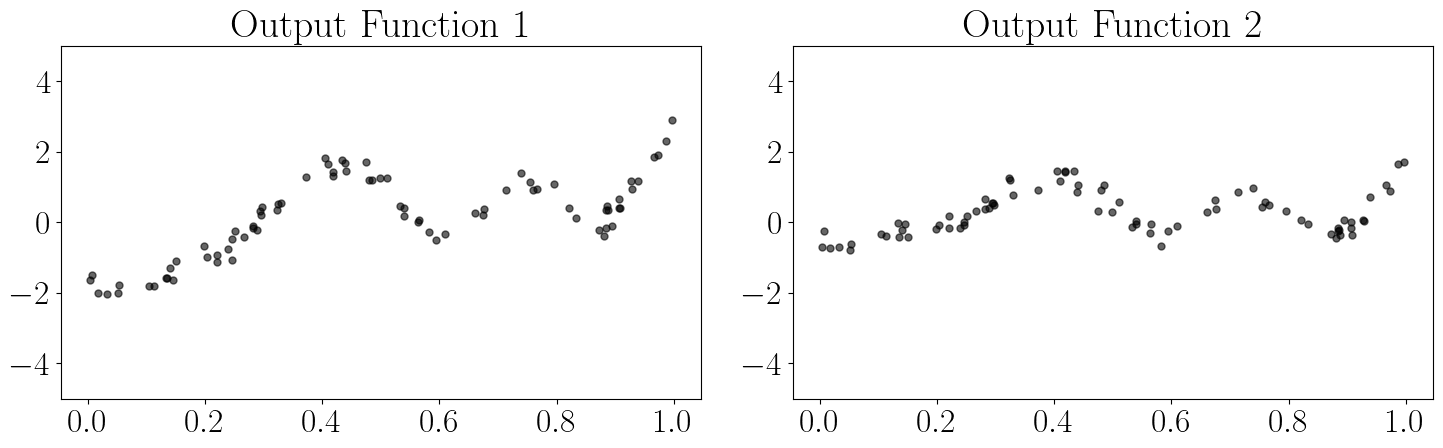

740
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


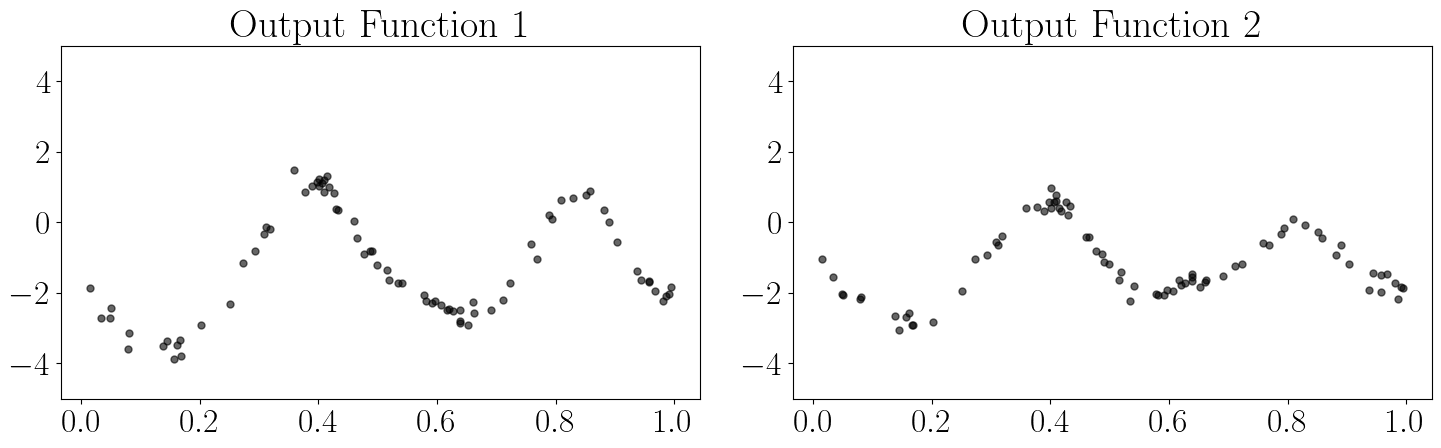

747
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


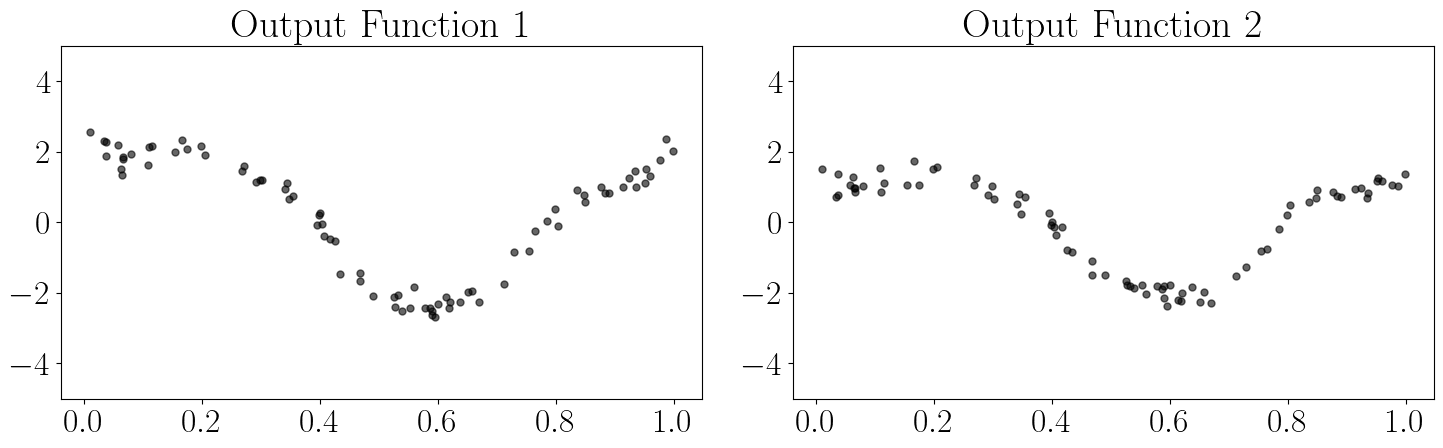

749
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


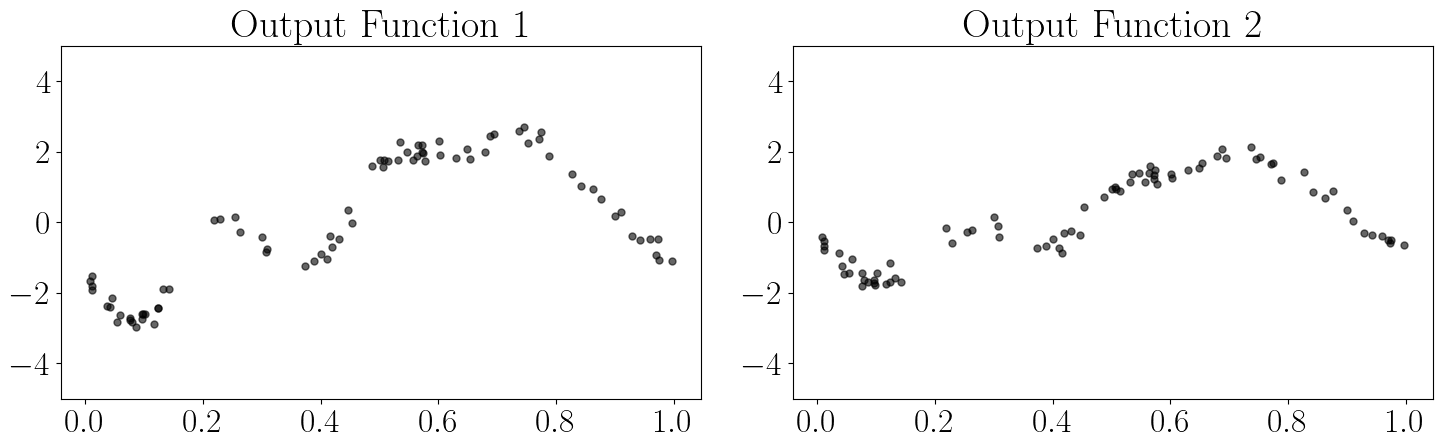

In [116]:
for i in range(500, 750):
    np.random.seed(i)
    # print(i)
    # Initialisation
    constant_mean = 0
    length_scale = 0.1
    variance = 1
    n_outputs = 2
    n_points = 160
    overlap_ratio = 1

    noise_variance = 0.04

    A = np.array([[1.414, 0], 
        [0.884, 0.468]])
    B = A @ A.T
    # print(B)

    D = B.shape[0]

    # Simulation
    mean_func = ConstantMean(constant=constant_mean)
    rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

    x_train = np.sort(np.random.uniform(0, 1, 80)).reshape(-1, 1)
    N = len(x_train)
    kernel_train = rbf_kernel(x_train, x_train)
    K_train = np.kron(B, kernel_train)
    K_train_noise = K_train + np.kron(noise_variance * np.eye(D), np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
    y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

    y_train = apply_overlap(y_train, overlap_ratio)

    # indices_025 = np.where((x_train >= 0.40) & (x_train <= 0.50))[0]
    # outlier_indices_025 = np.random.choice(indices_025, int(4), replace=False)
    # y_train[outlier_indices_025, 0] = 2

    x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

    if np.abs(y_train[0,0]) > 1.5:
        print(i)
        print(B)

        # Plotting
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        for i in range(2):
            axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1}')
            axs[i].set_title(f"Output Function {i+1}")
            axs[i].set_ylim([-5, 5])
            # axs[i].legend()

        plt.tight_layout()
        plt.show()

[[1.999396 1.200486]
 [1.200486 1.000642]]


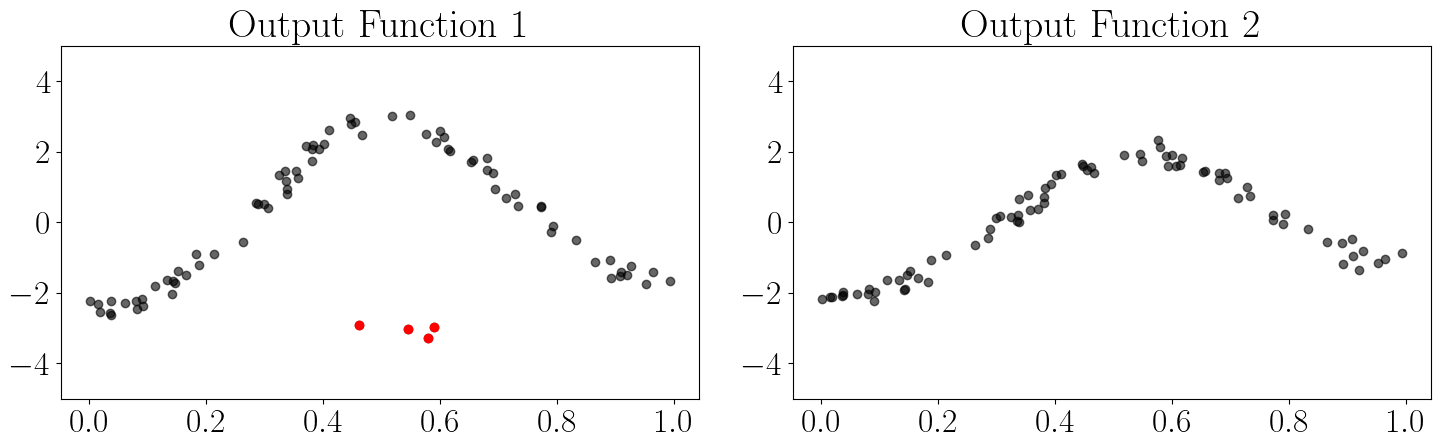

In [7]:
np.random.seed(48)
# Initialisation
epsilon = 0.05
constant_mean = 0
length_scale = 0.2
variance = 1
n_outputs = 2
n_points = 80
overlap_ratio = 1

A = np.array([[1.414, 0], 
    [0.849, 0.529]])
B = A @ A.T
print(B)

D = B.shape[0]

noise = np.array([0.04, 0.04])
if noise.shape[0] == 1:
    noise_matrix = noise * np.eye(D)
else:
    noise_matrix = np.diag(noise)

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.sort(np.random.uniform(0, 1, n_points)).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_matrix, np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

outlier_range = np.where((x_train >= 0.4) & (x_train <= 0.6))[0]
outlier_indices = np.random.choice(outlier_range, int(epsilon*n_points), replace=False)
y_train[outlier_indices, 0] = np.random.normal(loc=-3, scale=0.5, size=outlier_indices.shape[0])

# Mask to keep all indices that are NOT outliers
mask = np.ones(len(x_train), dtype=bool)
mask[outlier_indices] = False

y_train -= np.mean(y_train, axis=0)

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1}')
    if i == 0:
        axs[i].plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', label='Outlier points')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-5, 5])
    # axs[i].legend()

plt.tight_layout()
plt.show()

In [8]:
# Instantiate and train
mogp = MOGPRegressor(mean = 0, length_scale=0.1, noise = noise, A=A)
mogp.fit(x_train, y_train)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_B = mogp.B
optim_A = mogp.A
optim_noise = mogp.noise

Optimized length_scale: 0.2702
Optimized noise: [1.54722745 0.03979993]
Optimized A: [[1.66932682 0.30147195]
 [1.49443625 0.55699221]]
Optimized B: 
[[2.87753737 2.66262004]
 [2.66262004 2.54358002]]


Optimized length_scale: 0.1848
Optimized noise: [0.03178746 0.02070625]
Optimized A: [[1.44317768 0.16144076]
 [0.99017515 0.48151699]]
Optimized B: 
[[2.10882493 1.50673514]
 [1.50673514 1.21230544]]


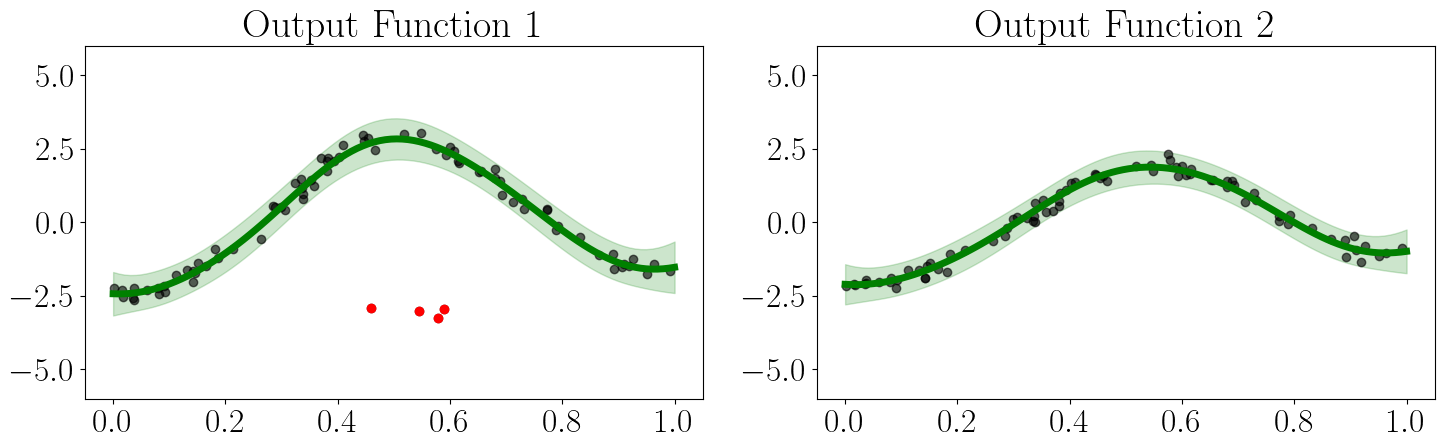

In [9]:
# Instantiate and train
morcgp = MORCGPRegressor(mean = 0, length_scale=0.1, noise = noise, A=optim_A)
predictive_mean, predictive_variances = morcgp.fit(x_train, y_train)

# print(morcgp.loo_cv(length_scale=0.1, noise=0.04, A=A, weighted=True, B_weighted=B))

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=False, B_weighted=optim_B, noise_weighted=optim_noise)


# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1}')
    if i == 0:
        axs[i].plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', label='Outlier points')

    # axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x_train.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='green', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

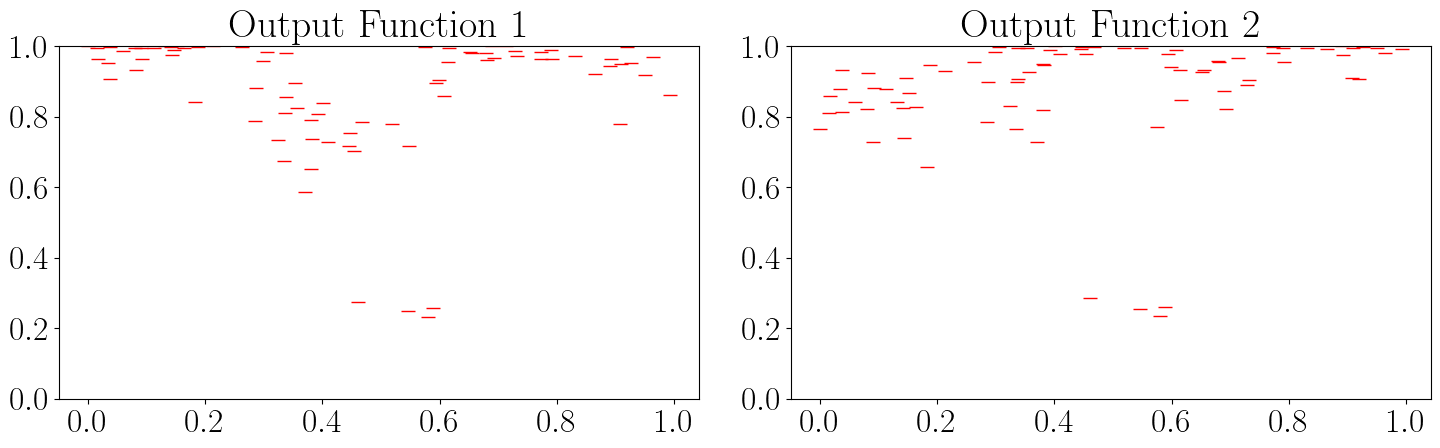

In [10]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):

    axs[i].plot(x_train.flatten(), ((morcgp.weights_01.reshape(n_outputs,-1).T))[:,i], '_', color='red', label=f'Predictive Mean', markersize=10)

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([0, 1])

plt.tight_layout()
plt.show()

Optimized length_scale: 0.0986, noise: 0.235257, rbf_variance: 0.4777
Optimized length_scale: 0.2895, noise: 0.029838, rbf_variance: 1.9089


(-6.0, 6.0)

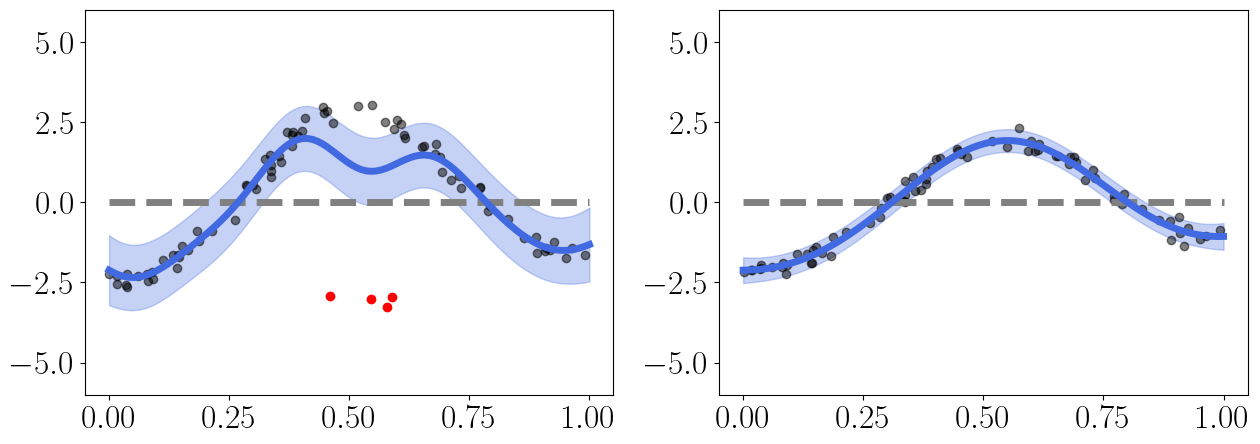

In [11]:
y_train1, y_train2 = y_train[:, 0].reshape(-1,1), y_train[:, 1].reshape(-1,1)

# Plot 1 ------------------

constant_mean = ConstantMean(constant=0)
rcgp1 = RCGPRegressor(mean=constant_mean, length_scale=0.2, rbf_variance=2, noise=0.04, epsilon=epsilon)
rcgp1.fit(x_train, y_train1)
rcgp1.optimize_loo_cv(weighted=False, print_opt_param=True)

mu1, var1 = rcgp1.predict(x_test)
std1 = np.sqrt(var1 + rcgp1.noise)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(x_train[mask], y_train1[mask], 'o', color='black', alpha=0.5)
axs[0].plot(x_train[~mask], y_train1[~mask], 'o', color='red')
axs[0].plot(x_test, n_points * np.zeros((len(x_test), 1)), '--', color='grey')
axs[0].plot(x_test, mu1.ravel(), color="royalblue")
axs[0].fill_between(x_test.ravel(), mu1.ravel() - 1.96 * std1, mu1.ravel() + 1.96 * std1, alpha=0.3, color='royalblue')
axs[0].set_ylim([-6, 6])

# Plot 2 ------------------

rcgp2 = RCGPRegressor(mean=constant_mean, length_scale=0.2, rbf_variance=2, noise=0.04, epsilon=epsilon)
rcgp2.fit(x_train, y_train2)
rcgp2.optimize_loo_cv(weighted=False, print_opt_param=True)

mu2, var2 = rcgp2.predict(x_test)
std2 = np.sqrt(var2 + rcgp2.noise)

axs[1].plot(x_train[mask], y_train2[mask], 'o', color='black', alpha=0.5)
# axs[1].plot(x_train[~mask], y_train2[~mask], 'o', color='red')
axs[1].plot(x_test, n_points * np.zeros((len(x_test), 1)), '--', color='grey')
axs[1].plot(x_test, mu2.ravel(), color="royalblue")
axs[1].fill_between(x_test.ravel(), mu2.ravel() - 1.96 * std2, mu2.ravel() + 1.96 * std2, alpha=0.3, color='royalblue')
axs[1].set_ylim([-6, 6])


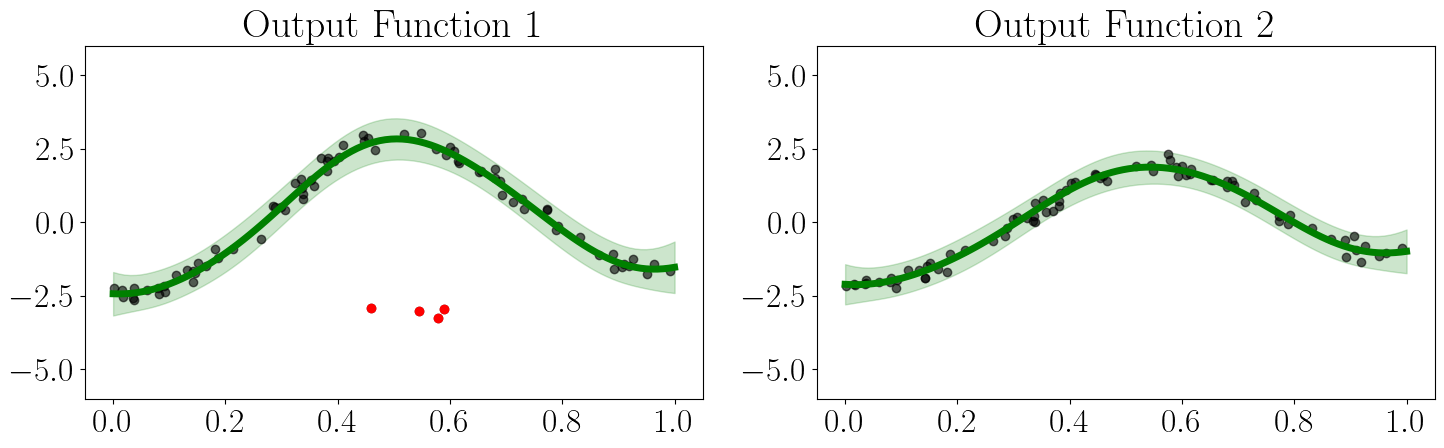

In [12]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1}')
    if i == 0:
        axs[i].plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', label='Outlier points')

    # axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x_train.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='green', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

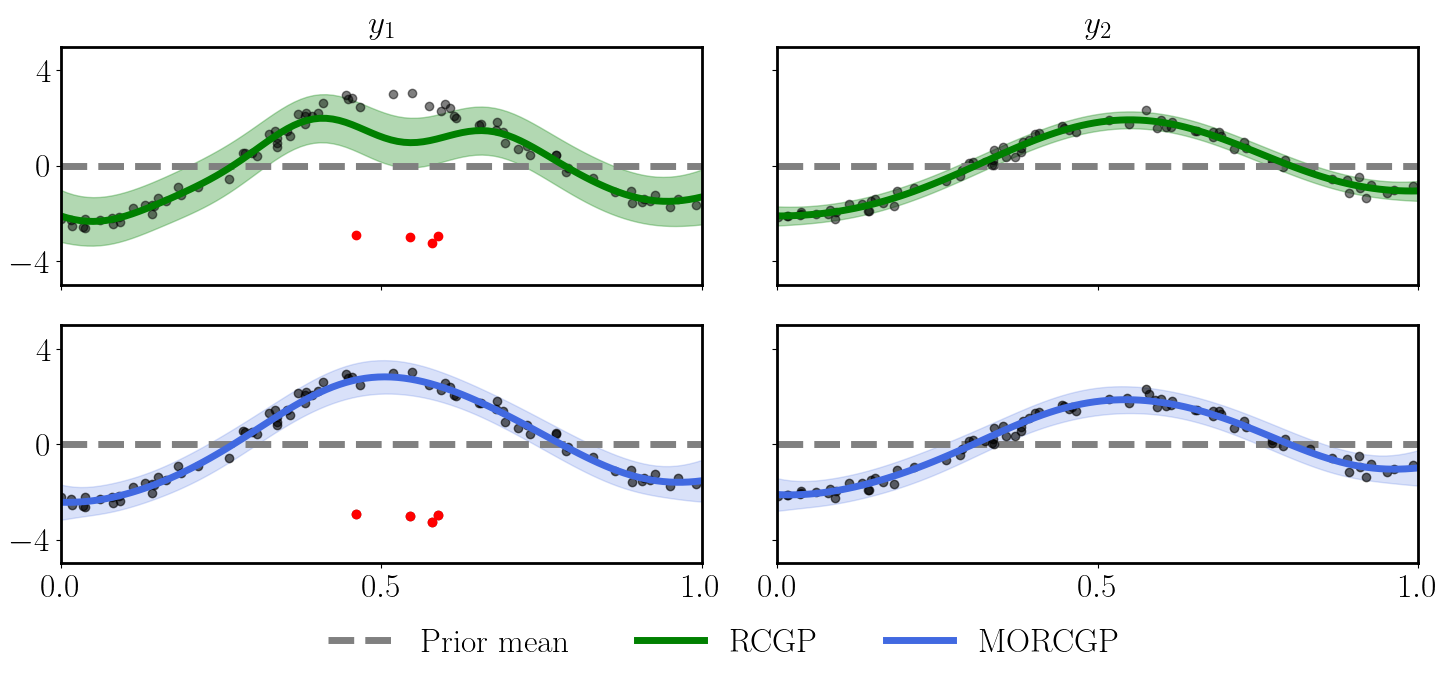

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 7))

# -------- Plot 1: RCGP on y_train1 --------
constant_mean = ConstantMean(constant=0)
rcgp1 = RCGPRegressor(mean=constant_mean, length_scale=0.2, rbf_variance=2, noise=0.04, epsilon=epsilon)
rcgp1.fit(x_train, y_train[:, 0].reshape(-1,1))
rcgp1.optimize_loo_cv(weighted=False, print_opt_param=False)

mu1, var1 = rcgp1.predict(x_test)
std1 = np.sqrt(var1 + rcgp1.noise)

axs[0, 0].plot(x_train[mask], y_train[mask, 0], 'o', color='black', alpha=0.5)
axs[0, 0].plot(x_train[~mask], y_train[~mask, 0], 'o', color='red')
axs[0, 0].plot(x_test, n_points * np.zeros((len(x_test), 1)), '--', color='grey')
axs[0, 0].plot(x_test, mu1.ravel(), color="green")
axs[0, 0].fill_between(x_test.ravel(), mu1.ravel() - 1.96 * std1, mu1.ravel() + 1.96 * std1, alpha=0.3, color='green')
axs[0, 0].set_title('$y_1$', fontsize=24, pad=10)

# -------- Plot 2: RCGP on y_train2 --------
rcgp2 = RCGPRegressor(mean=constant_mean, length_scale=0.2, rbf_variance=2, noise=0.04, epsilon=epsilon)
rcgp2.fit(x_train, y_train[:, 1].reshape(-1,1))
rcgp2.optimize_loo_cv(weighted=False, print_opt_param=False)

mu2, var2 = rcgp2.predict(x_test)
std2 = np.sqrt(var2 + rcgp2.noise)

axs[0, 1].plot(x_train[mask], y_train[mask, 1], 'o', color='black', alpha=0.5)
# axs[0, 1].plot(x_train[~mask], y_train[~mask, 1], 'o', color='red')
axs[0, 1].plot(x_test, n_points * np.zeros((len(x_test), 1)), '--', color='grey')
axs[0, 1].plot(x_test, mu2.ravel(), color="green", label='RCGP')
axs[0, 1].fill_between(x_test.ravel(), mu2.ravel() - 1.96 * std2, mu2.ravel() + 1.96 * std2, alpha=0.3, color='green')
axs[0, 1].set_title('$y_2$', fontsize=24, pad=10)
# axs[0, 1].legend()

# -------- Plot 3: Multi-output prediction for y_train1 --------
axs[1, 0].plot(x_test, n_points * np.zeros((len(x_test), 1)), '--', color='grey')
axs[1, 0].plot(x_train.flatten(), y_train[:, 0], 'o', color='black', alpha=0.6)
axs[1, 0].plot(x_train.flatten()[~mask], y_train[:, 0][~mask], 'o', color='red')
axs[1, 0].plot(x_test.flatten(), mu_morcgp[:, 0], '-', color='royalblue', label='MORCGP')
axs[1, 0].fill_between(x_test.flatten(), mu_morcgp[:, 0] - 2*std_morcgp[:, 0], mu_morcgp[:, 0] + 2*std_morcgp[:, 0], color='royalblue', alpha=0.2)

# -------- Plot 4: Multi-output prediction for y_train2 --------
axs[1, 1].plot(x_test, n_points * np.zeros((len(x_test), 1)), '--', color='grey')
axs[1, 1].plot(x_train.flatten(), y_train[:, 1], 'o', color='black', alpha=0.6)
axs[1, 1].plot(x_test.flatten(), mu_morcgp[:, 1], '-', color='royalblue', label='MORCGP')
axs[1, 1].fill_between(x_test.flatten(), mu_morcgp[:, 1] - 2*std_morcgp[:, 1], mu_morcgp[:, 1] + 2*std_morcgp[:, 1], color='royalblue', alpha=0.2)
# axs[1, 1].legend()

for ax in axs.flat:
    ax.set_ylim([-5, 5])
    ax.set_xticks([0, 0.5, 1])
    ax.set_xlim([0, 1])
    for spine in ax.spines.values():
        spine.set_linewidth(2) 

# Show y-ticks only with labels on left plots, hide labels on right
for i in range(2):
    axs[i, 0].set_yticks([-4, 0, 4])          # Left: ticks and labels
    axs[i, 1].set_yticks([-4, 0, 4])          # Right: ticks only
    axs[i, 1].set_yticklabels([])             # Right: no labels

# for ax in axs[:, 0]:
#     ax.set_ylabel('$y_1$', fontsize=24, rotation=0, labelpad=10, va='center', ha='right')

# for ax in axs[:, 1]:
#     ax.set_ylabel('$y_2$', fontsize=24, rotation=0, labelpad=25, va='center', ha='left')

for ax in axs[0, :]:
    ax.set_xticklabels([])  # Remove the x-axis labels but keep the ticks


import matplotlib.lines as mlines

# Create custom legend handles
prior_mean_line = mlines.Line2D([], [], color='grey', linestyle='--', label='Prior mean')
rcgp_line = mlines.Line2D([], [], color='green', linestyle='-', label='RCGP')
morcgp_line = mlines.Line2D([], [], color='royalblue', linestyle='-', label='MORCGP')

# Place legend below all subplots, centered, 1 row, 3 columns
fig.legend(handles=[prior_mean_line, rcgp_line, morcgp_line],
           loc='lower center', bbox_to_anchor=(0.5, -0.02),
           ncol=3, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space at bottom for legend
plt.show()

# fig.savefig("./results/synthetic_MOGP_MORCGP.pdf", format='pdf', bbox_inches='tight')